In [90]:
import torch
from vectorhash import build_vectorhash_architecture
from smoothing import RatSLAMSmoothing, ArgmaxSmoothing, PolynomialSmoothing, SoftmaxSmoothing, SequentialSmoothing
from shifts import RollShift
from data_utils import load_mnist_dataset, prepare_data
from graph_utils import plot_imgs_side_by_side
from matplotlib import pyplot as plt
import itertools
device = "cuda"

In [91]:
N = 200
dataset = load_mnist_dataset()
obs, noisy_obs = prepare_data(dataset, num_imgs=N, device=device)

/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [92]:
percent_nonzero_relus = [
    0.01,
    0.1,
    0.3,
    0.5,
    0.7,
    0.99,
]
smoothings = [
    ArgmaxSmoothing(),
    PolynomialSmoothing(k=2),
    PolynomialSmoothing(k=4),
    SoftmaxSmoothing(T=0.003),
    SoftmaxSmoothing(T=0.01),
    SoftmaxSmoothing(T=0.3),
    RatSLAMSmoothing(device=device),
    RatSLAMSmoothing(device=device, sigma_xy=0.3, sigma_theta=0.3, inhibition_constant=0.00, delta_gamma=2),
    SequentialSmoothing([
        RatSLAMSmoothing(device=device),
        SoftmaxSmoothing(T=0.0002)
    ])
]

obs_results = torch.ones(
    len(smoothings) * len(percent_nonzero_relus), N, 3, device=device
)
noisy_obs_results = torch.ones(
    len(smoothings) * len(percent_nonzero_relus), N, 3, device=device
)
noise_results = torch.ones(
    len(smoothings) * len(percent_nonzero_relus), 3, device=device
)

noise = torch.randn(28 * 28, device=device)

limits = torch.Tensor([1, 1, 1])

test_cases = lambda: itertools.product(percent_nonzero_relus, smoothings)

for i, [sparsity, method] in enumerate(test_cases()):
    print(f"running experiment: sparsity={sparsity}, method={method}")
    model = build_vectorhash_architecture(
        shapes=[(5, 5, 5), (8, 8, 8)],
        N_h=1200,
        input_size=28 * 28,
        initalization_method="by_sparsity",
        percent_nonzero_relu=sparsity,
        device=device,
        smoothing=method,
        shift=RollShift(),
        relu=True,
        epsilon_hs=0.01,
        epsilon_sh=0.01,
    )
    for j in range(N):
        model.hippocampal_sensory_layer.learn(
            model.scaffold.hippocampal_from_grid(model.scaffold.G[i])[0], obs[i]
        )

    for k in range(N):
        obs_certainty, noisy_obs_certainty = [
            model.scaffold.estimate_certainty(
                g=model.scaffold.denoise(
                    model.scaffold.grid_from_hippocampal(
                        model.hippocampal_sensory_layer.hippocampal_from_sensory(o)
                    )
                )[0],
                limits=limits,
            )
            for o in [obs[k], noisy_obs[k]]
        ]
        obs_results[i, k] = obs_certainty
        noisy_obs_results[i, k] = noisy_obs_certainty
    noise_certainty = model.scaffold.estimate_certainty(
        g=model.scaffold.denoise(
            model.scaffold.grid_from_hippocampal(
                model.hippocampal_sensory_layer.hippocampal_from_sensory(noise)
            )
        )[0],
        limits=limits,
    )
    noise_results[i] = noise_certainty

running experiment: sparsity=0.01, method=ArgmaxSmoothing
by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  1200
running experiment: sparsity=0.01, method=PolynomialSmoothing (k=2)
by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  1200
running experiment: sparsity=0.01, method=PolynomialSmoothing (k=4)
by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  1200
running experiment: sparsity=0.01, method=SoftmaxSmoothing (T=0.003)
by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  1200
running experiment: sparsity=0.01, method=SoftmaxSmoothing (T=0.01)
by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  1200
running experiment: sparsity=0.01, method=SoftmaxSmoothing (T=0.3)
by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  1200
running 

In [94]:
import pickle
import os
basedir="experiments/certainty"
os.makedirs(basedir, exist_ok=True)

with open(f"{basedir}/obs_results.pkl", "wb") as f:
  pickle.dump(obs_results, f)

with open(f"{basedir}/noisy_obs_results.pkl", "wb") as f:
  pickle.dump(noisy_obs_results, f)

with open(f"{basedir}/noise_results.pkl", "wb") as f:
  pickle.dump(noise_results, f)


/tmp/ipykernel_24193/272043045.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


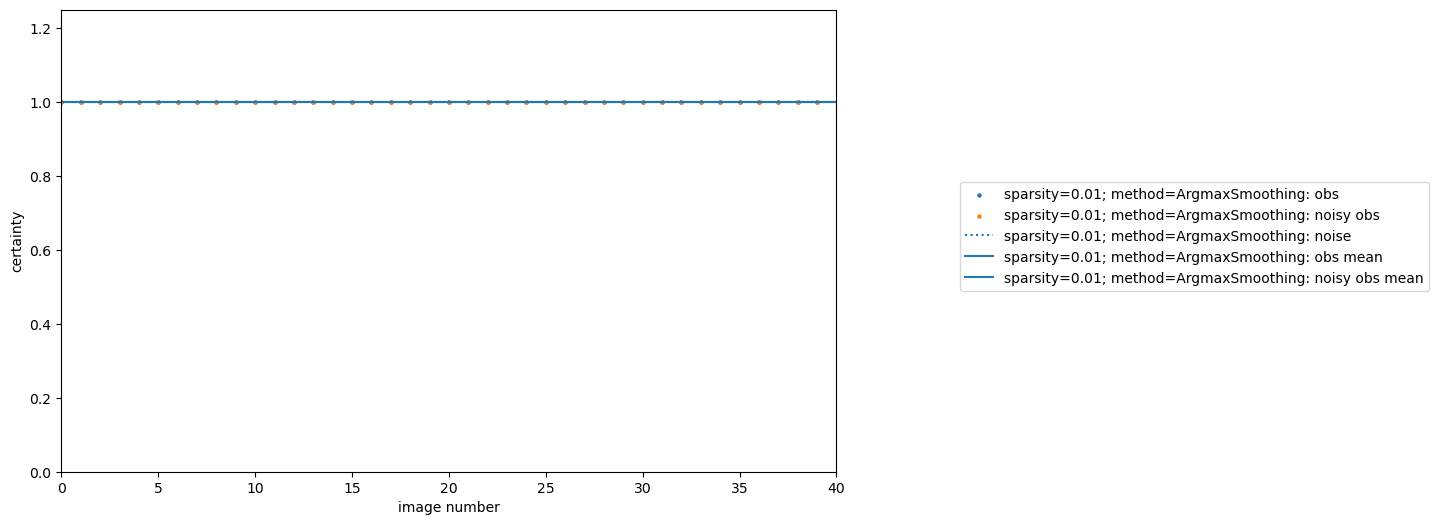

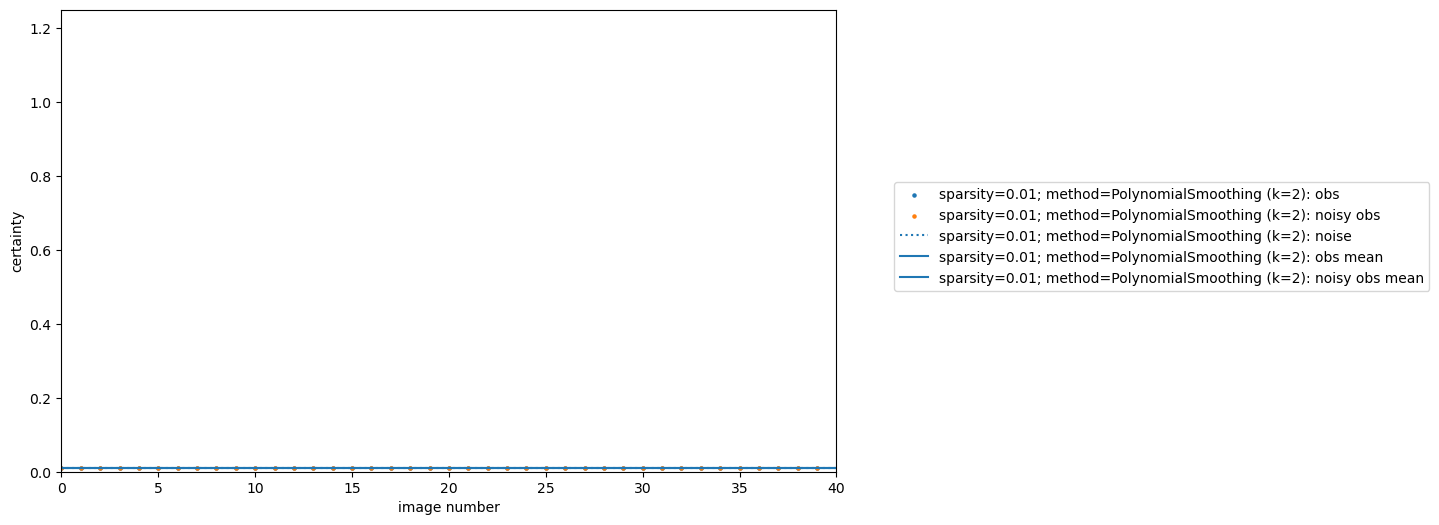

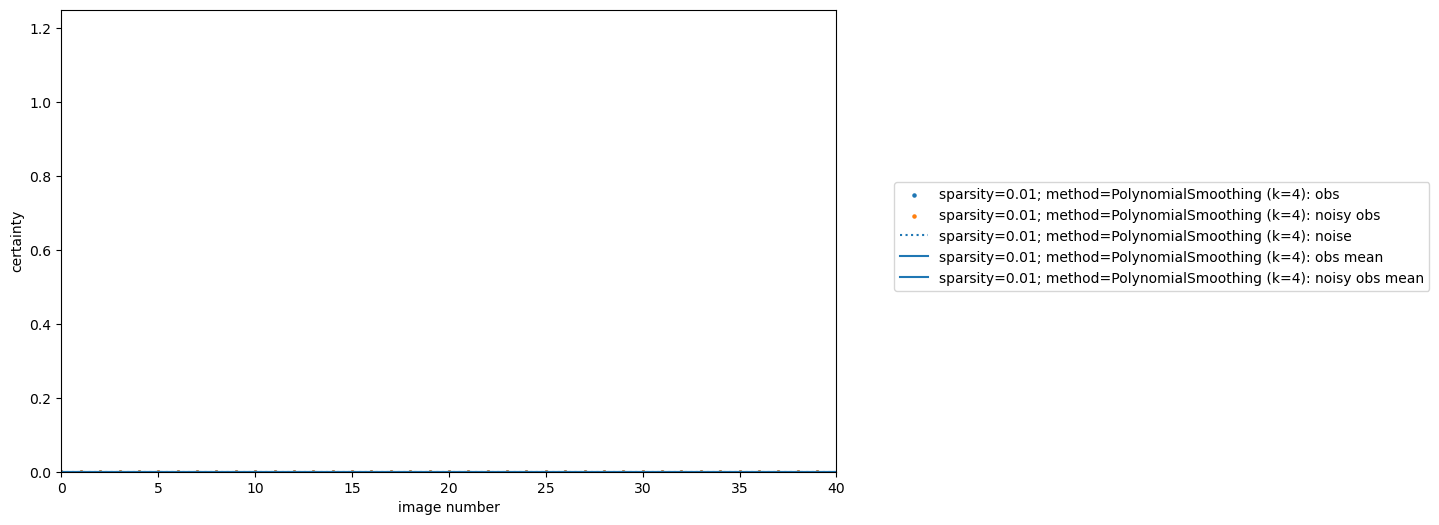

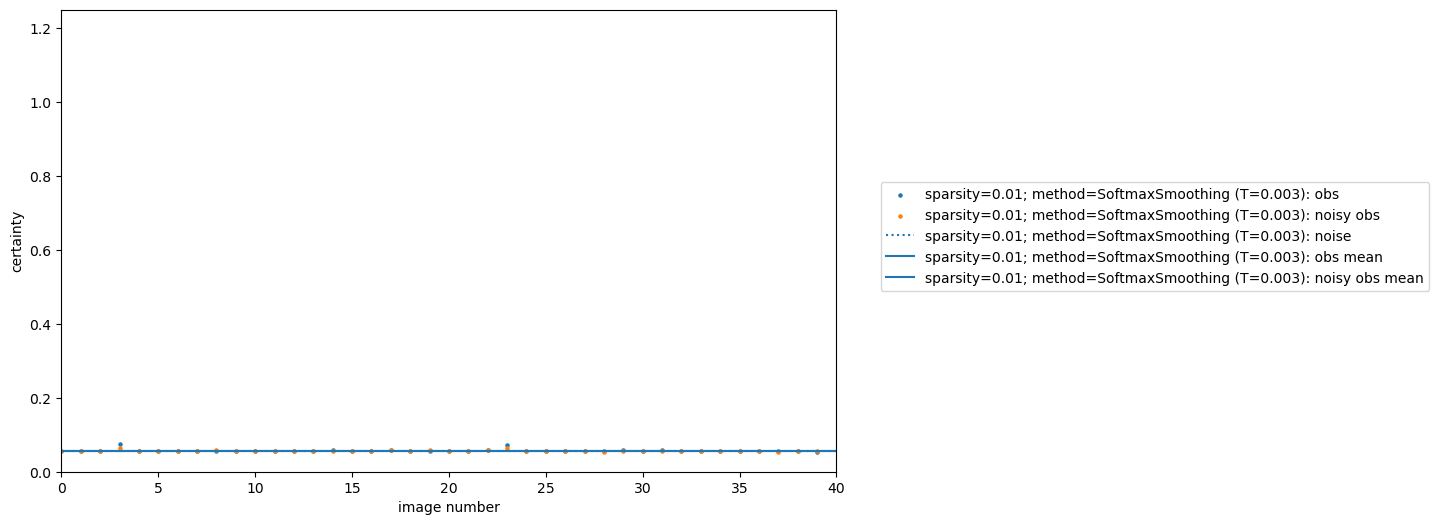

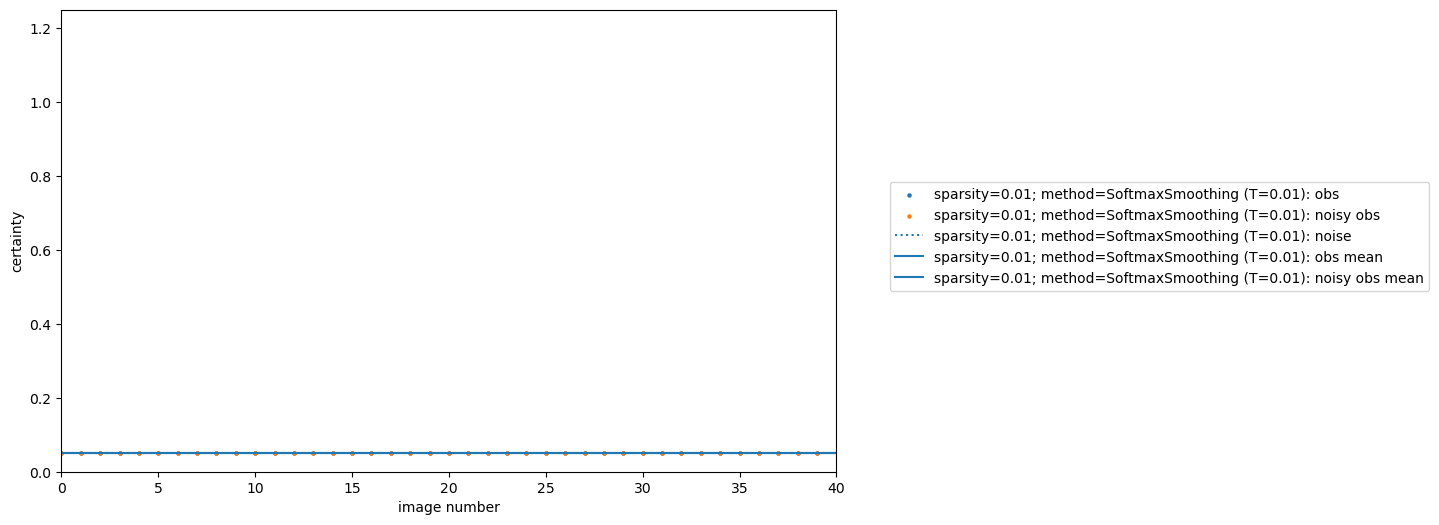

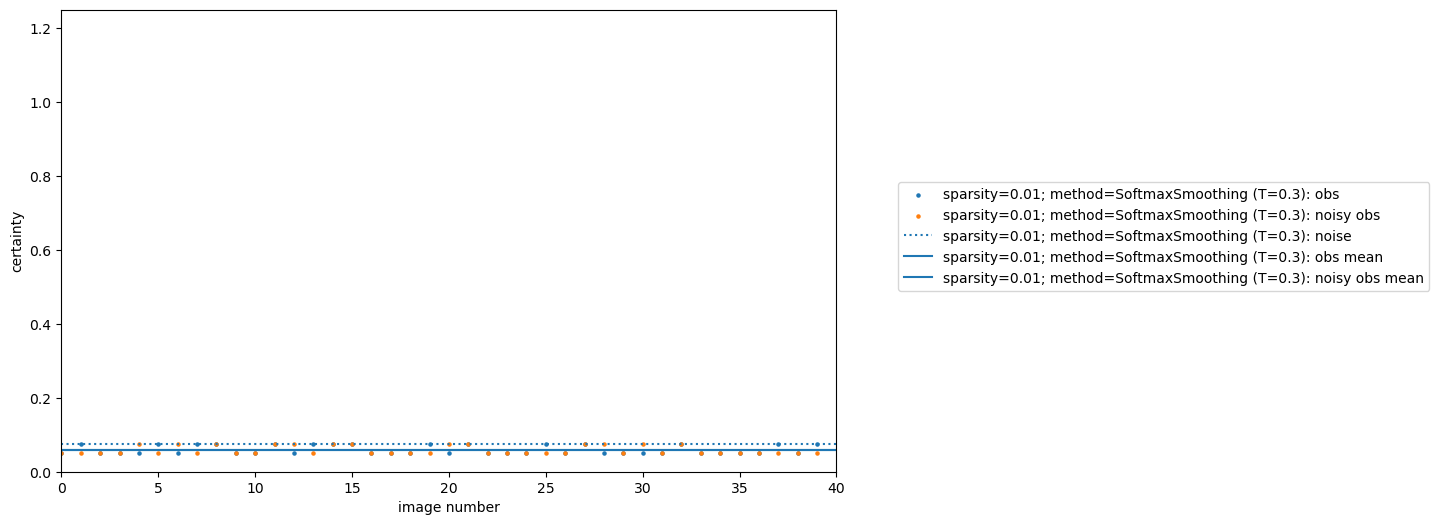

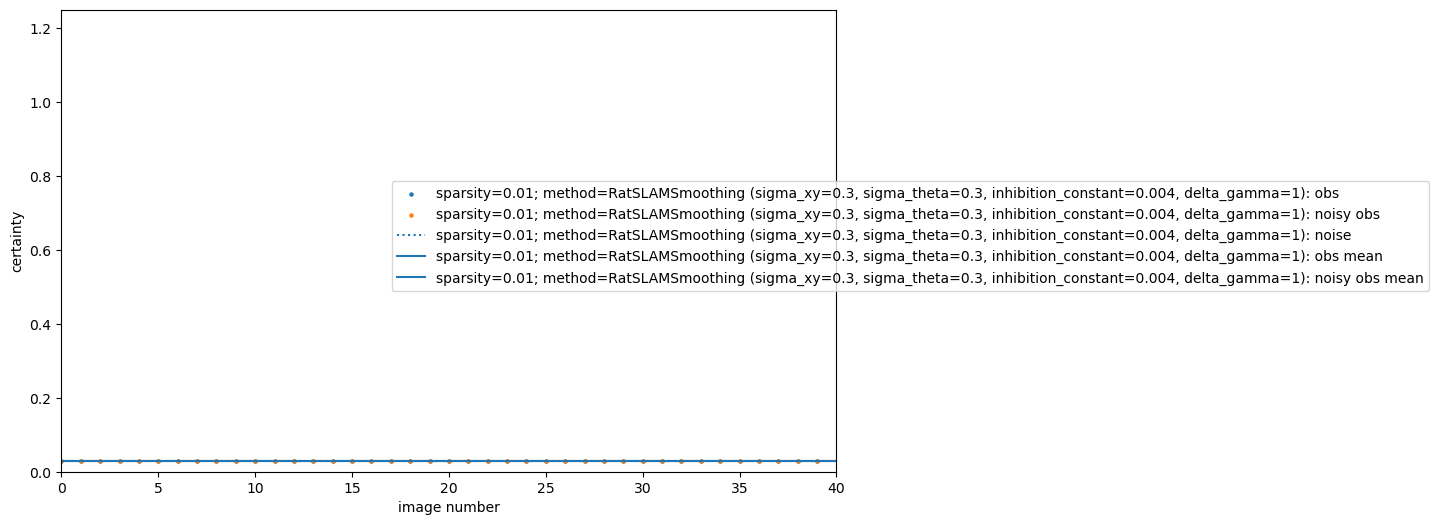

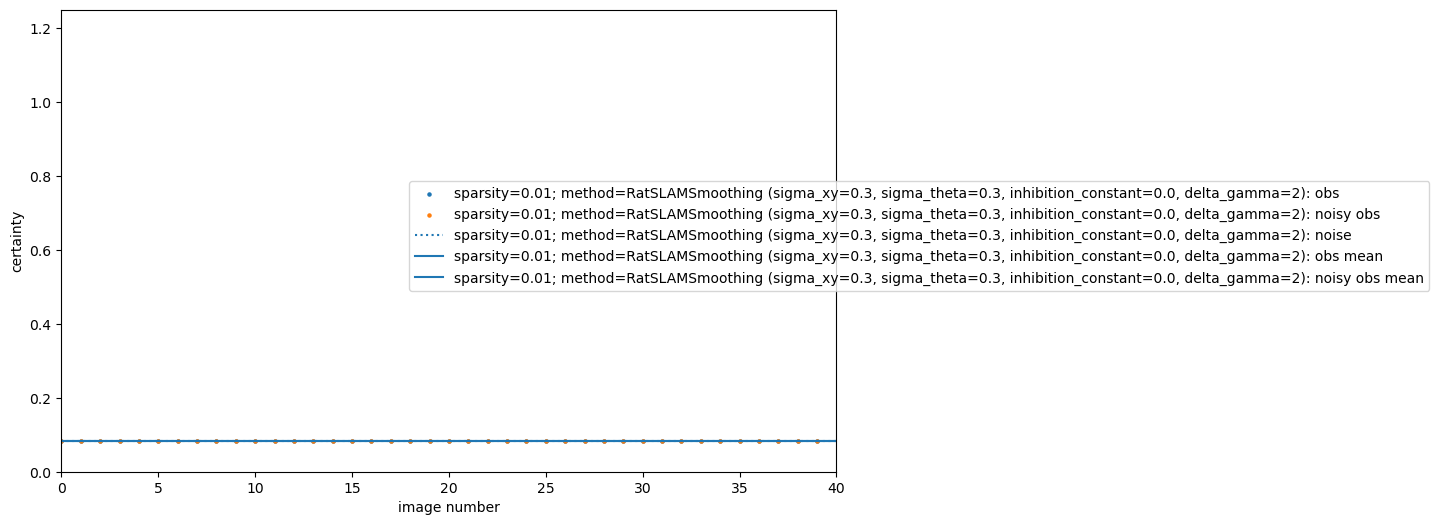

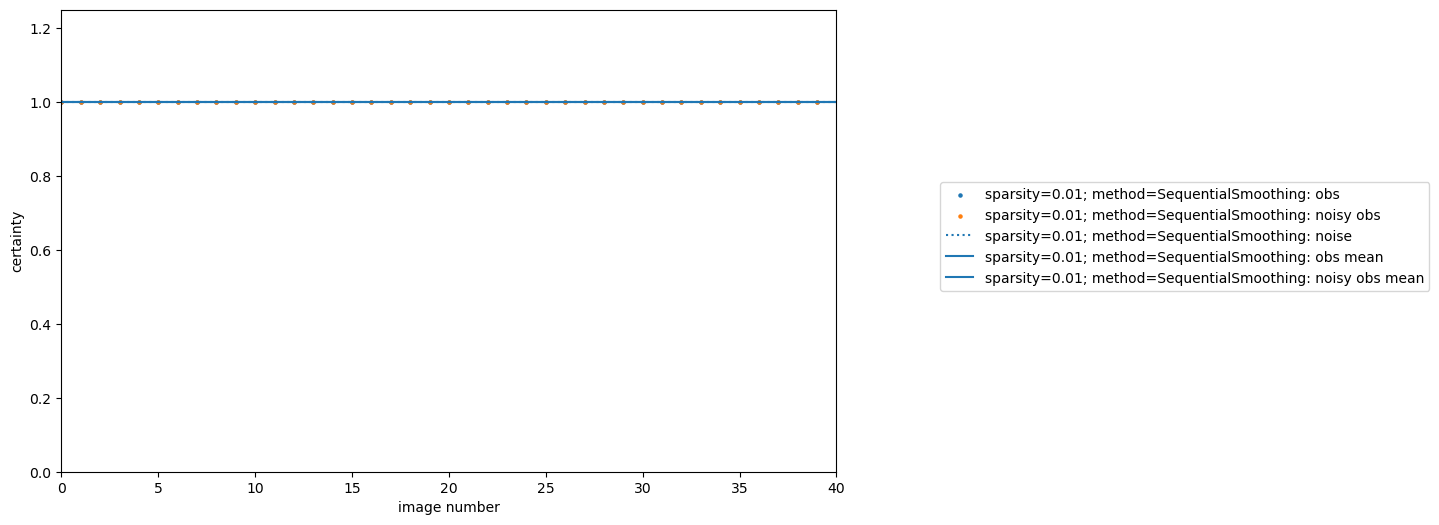

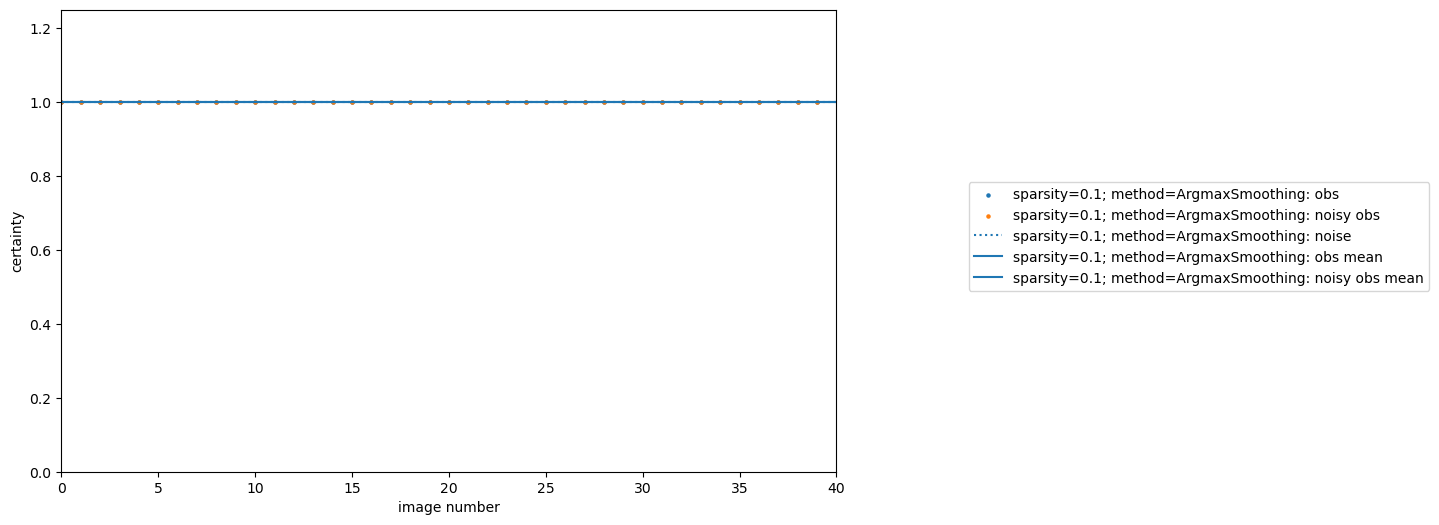

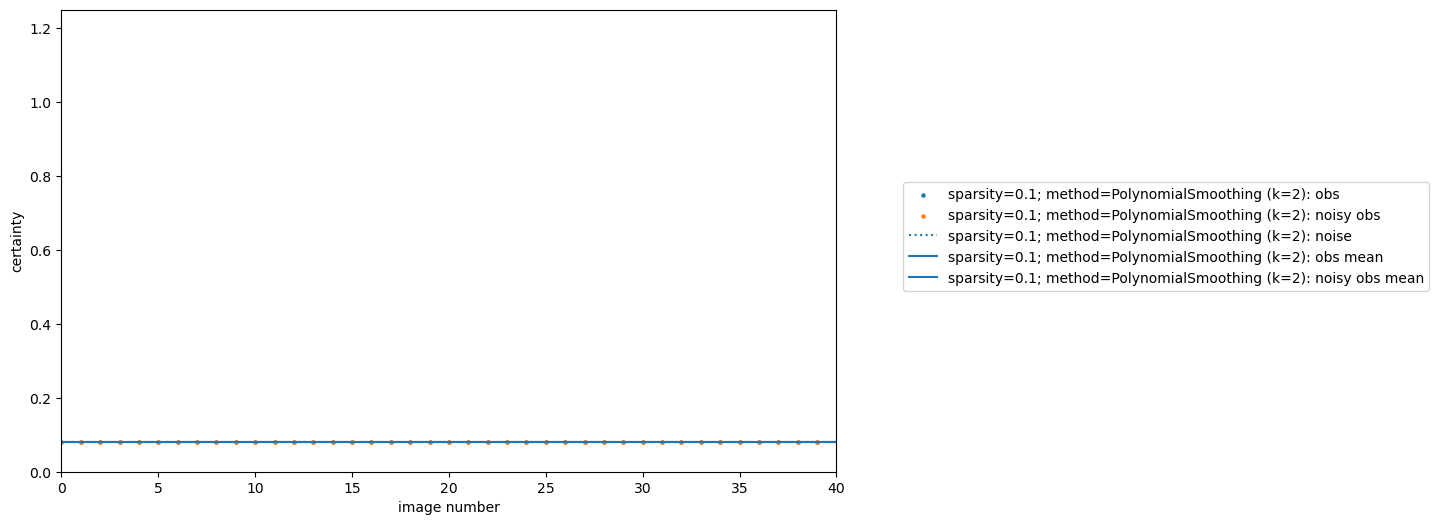

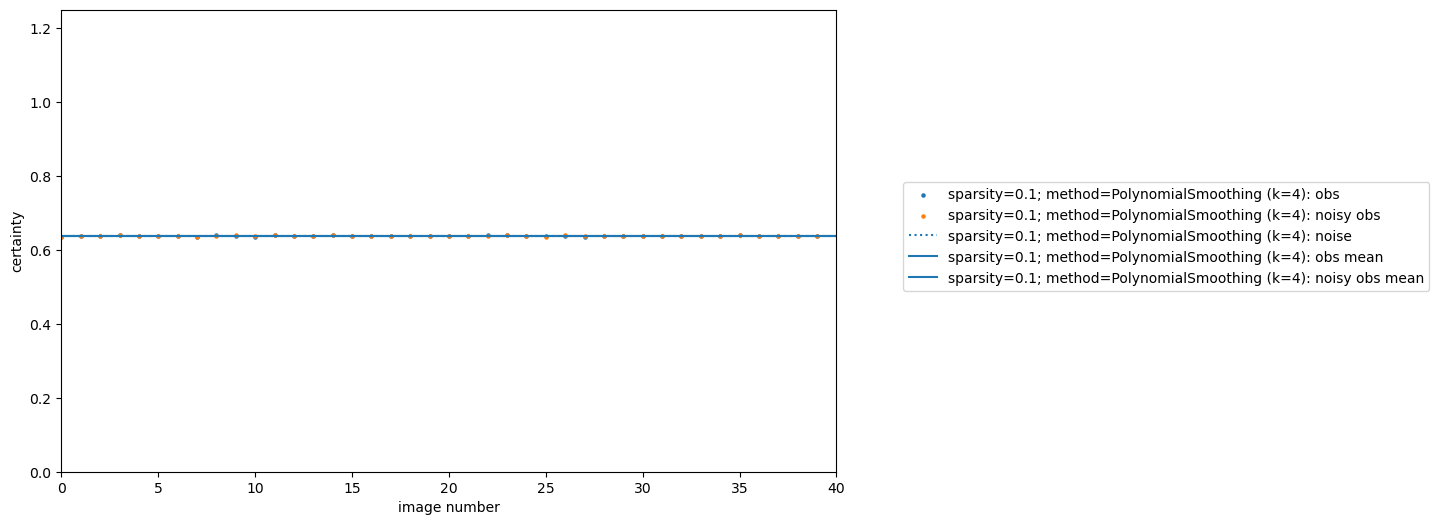

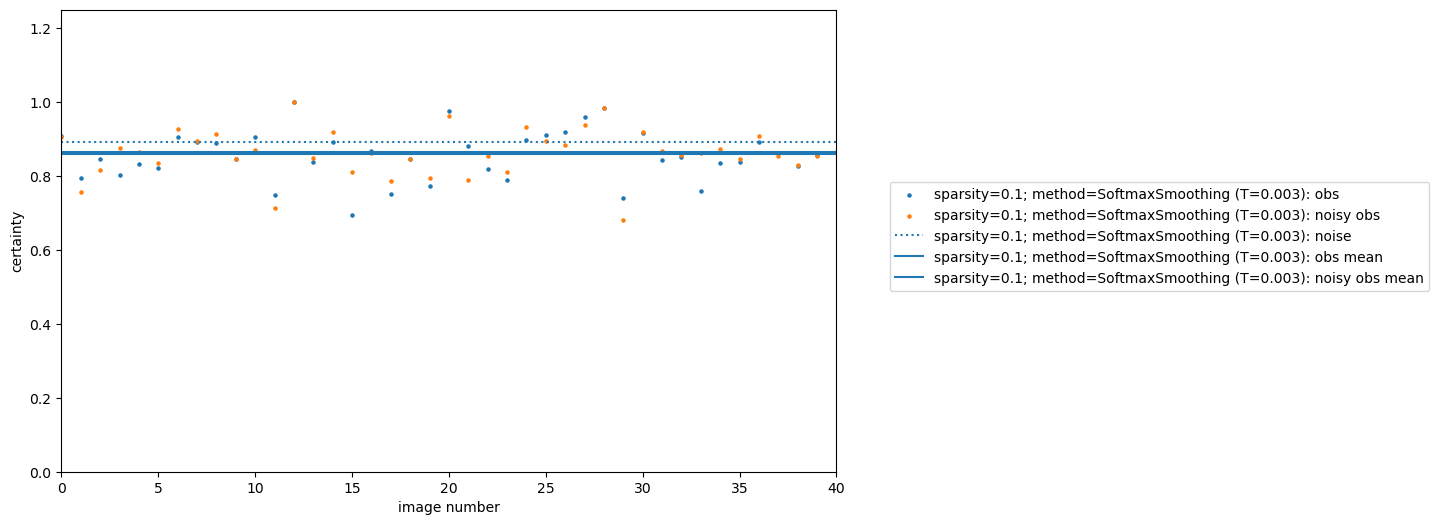

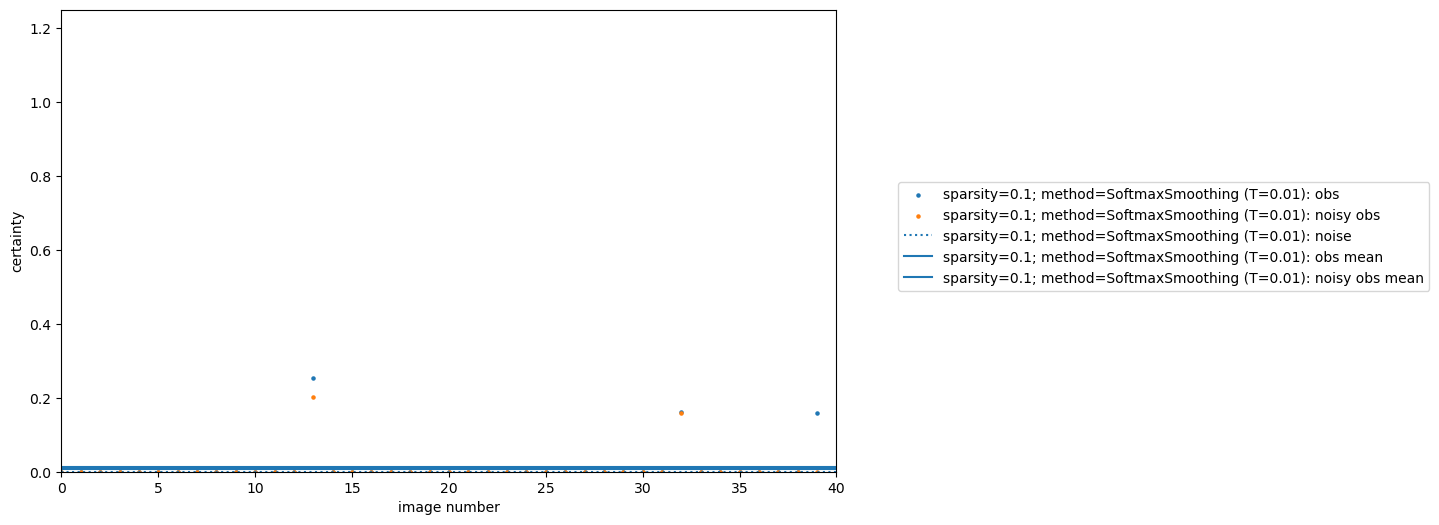

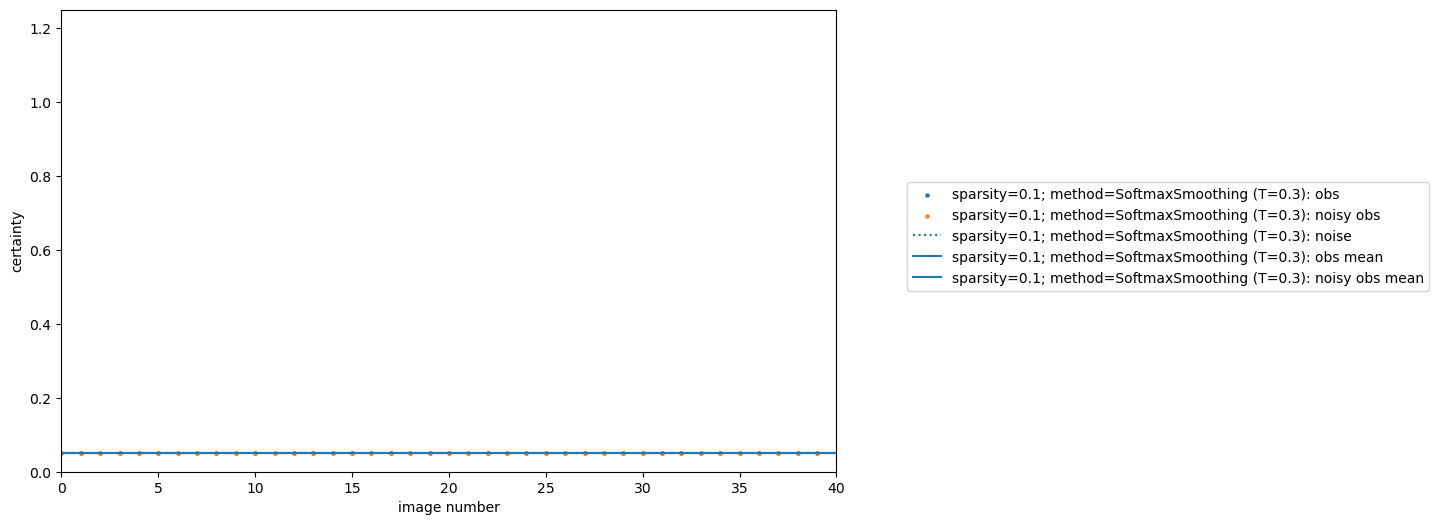

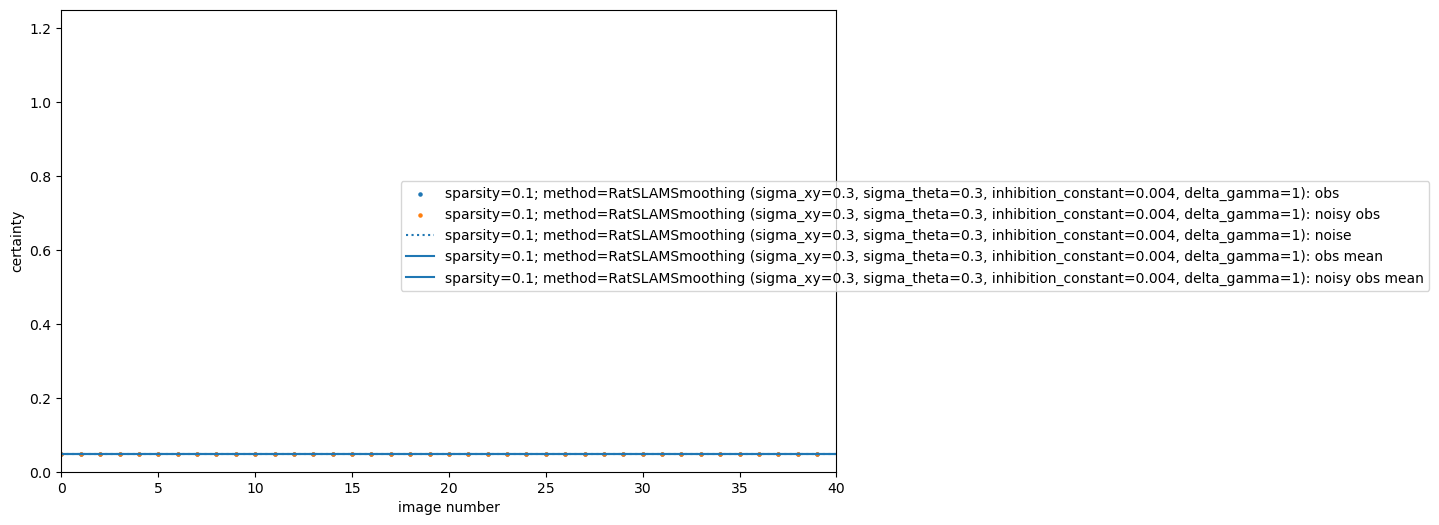

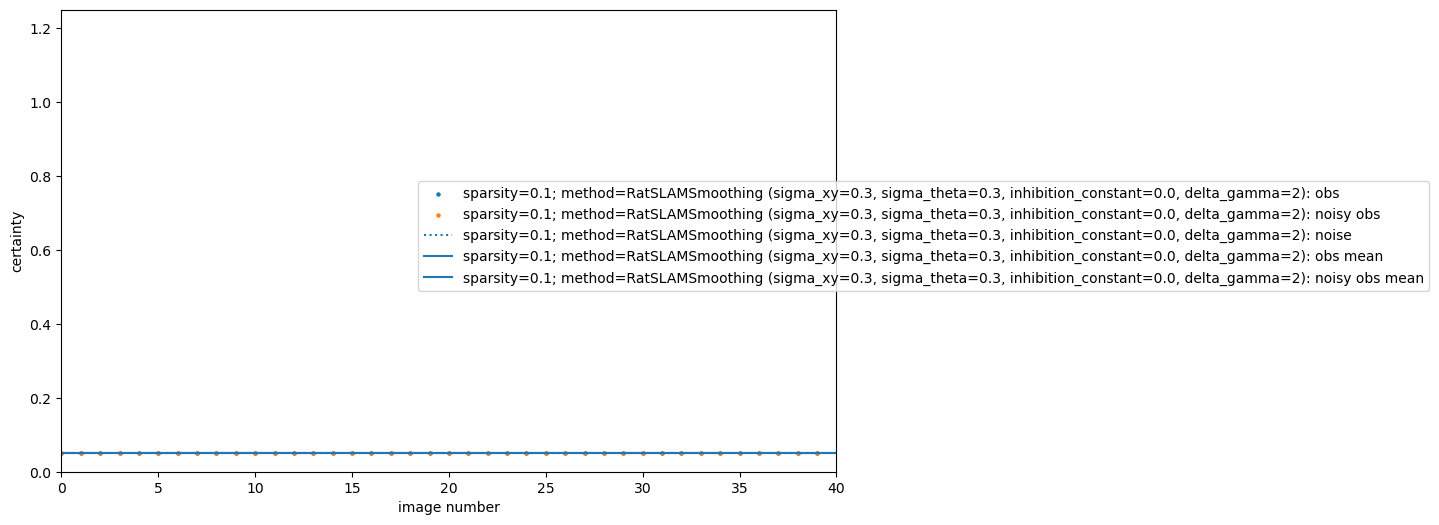

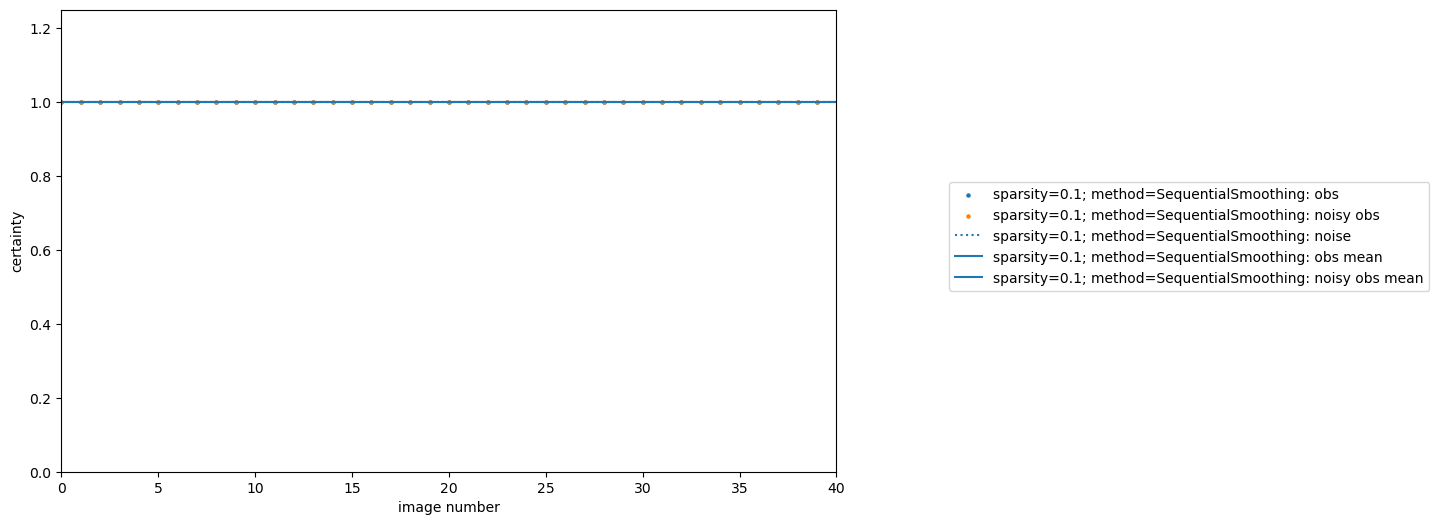

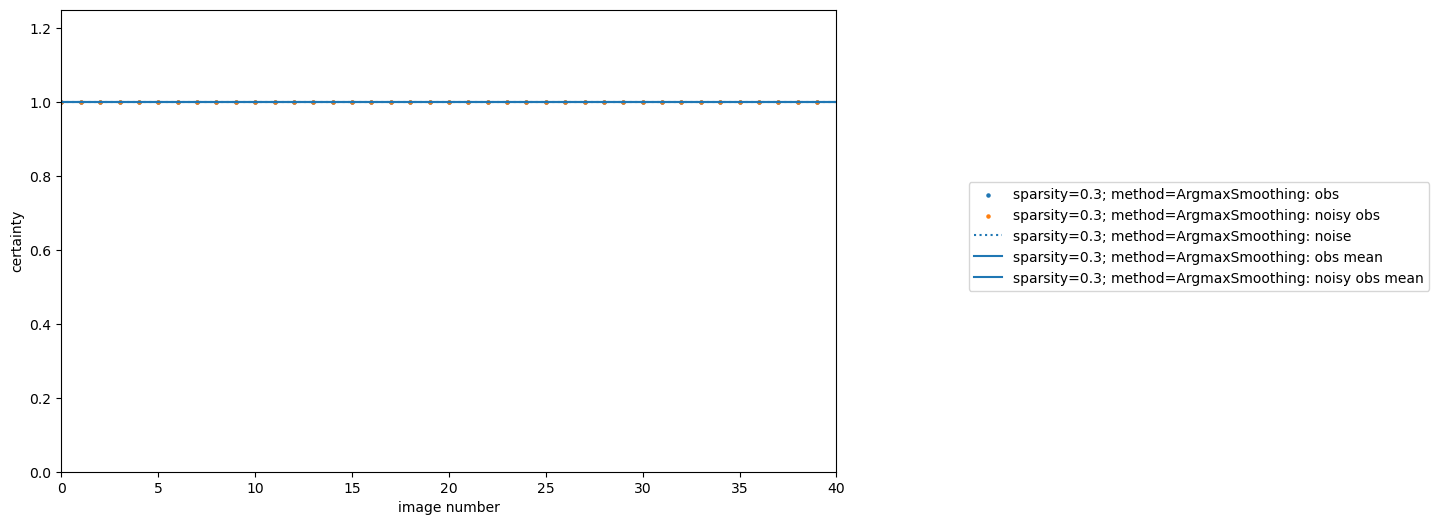

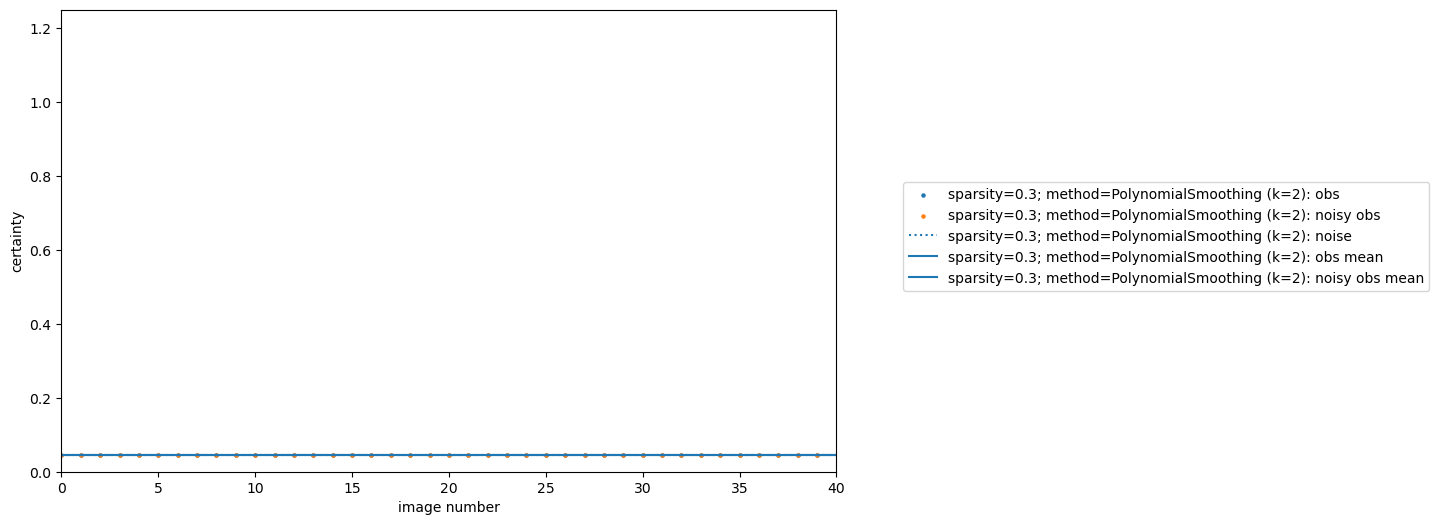

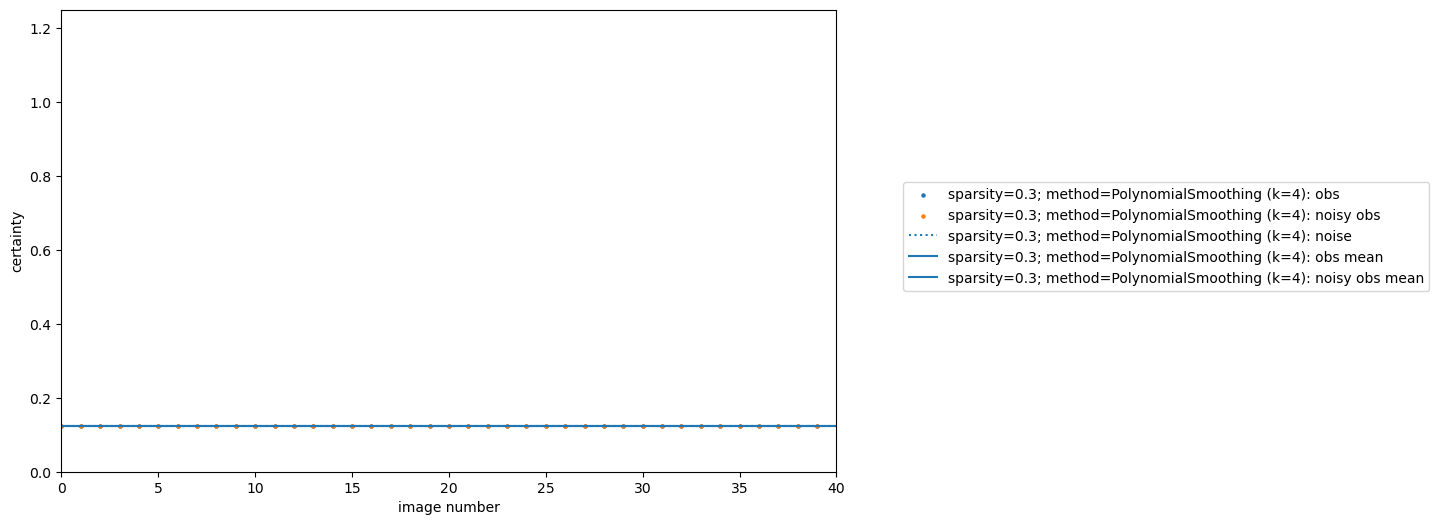

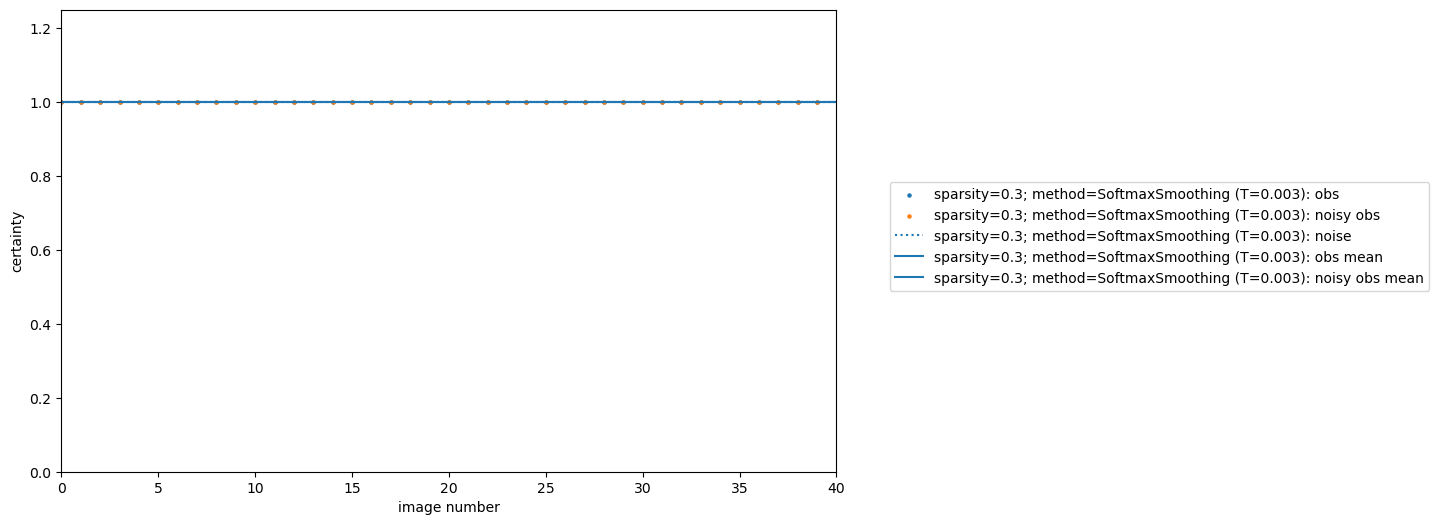

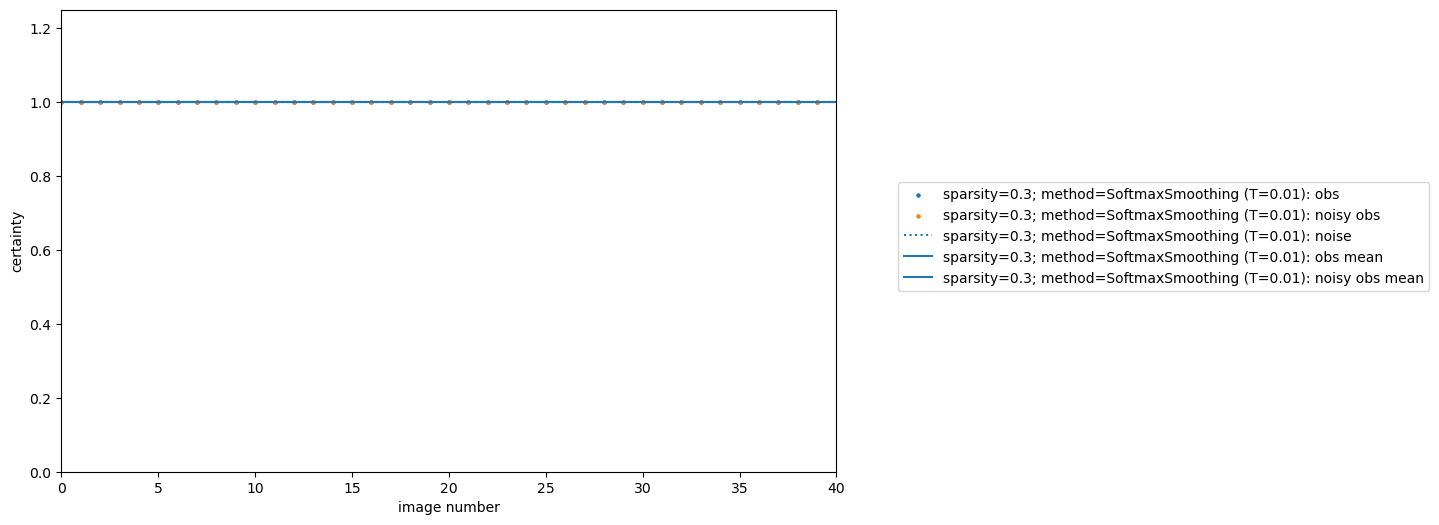

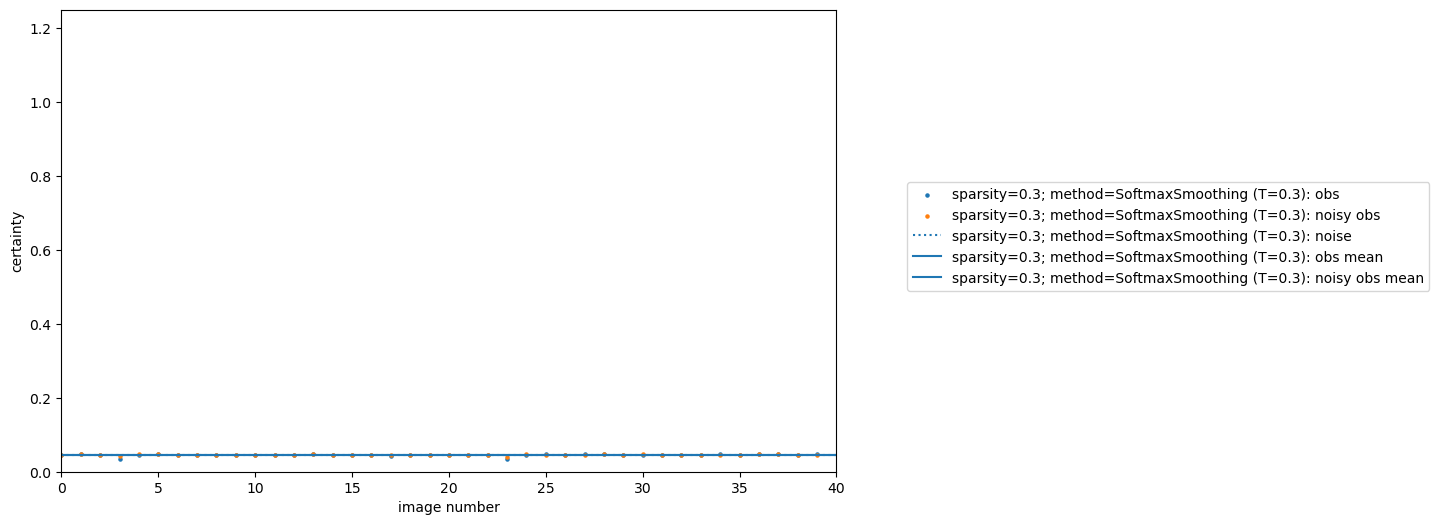

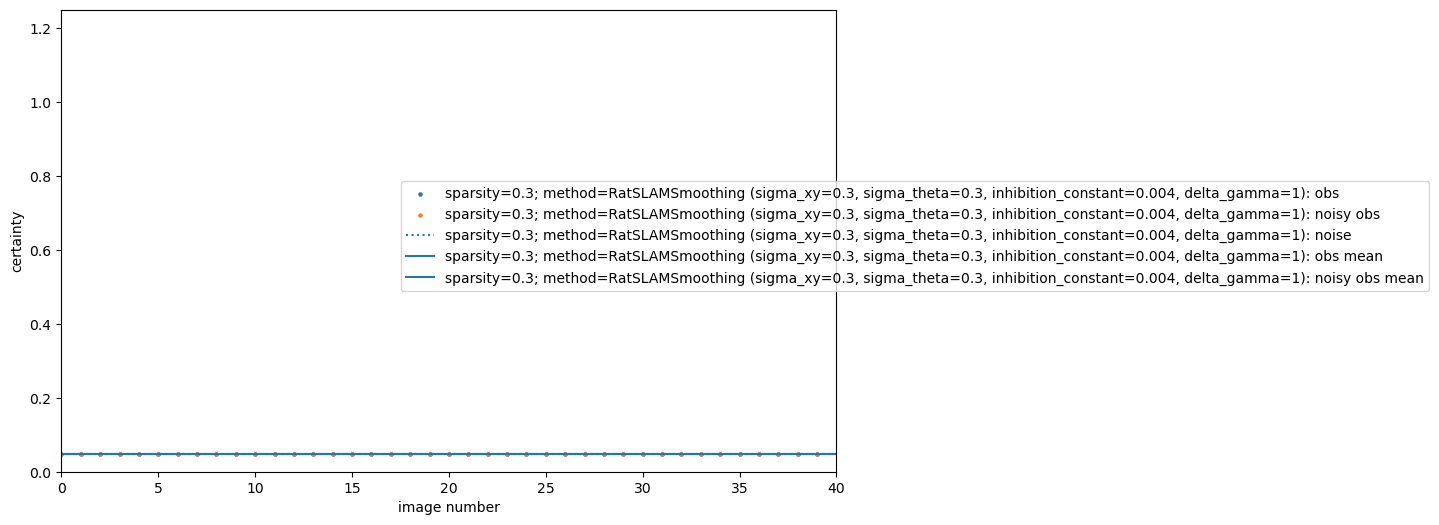

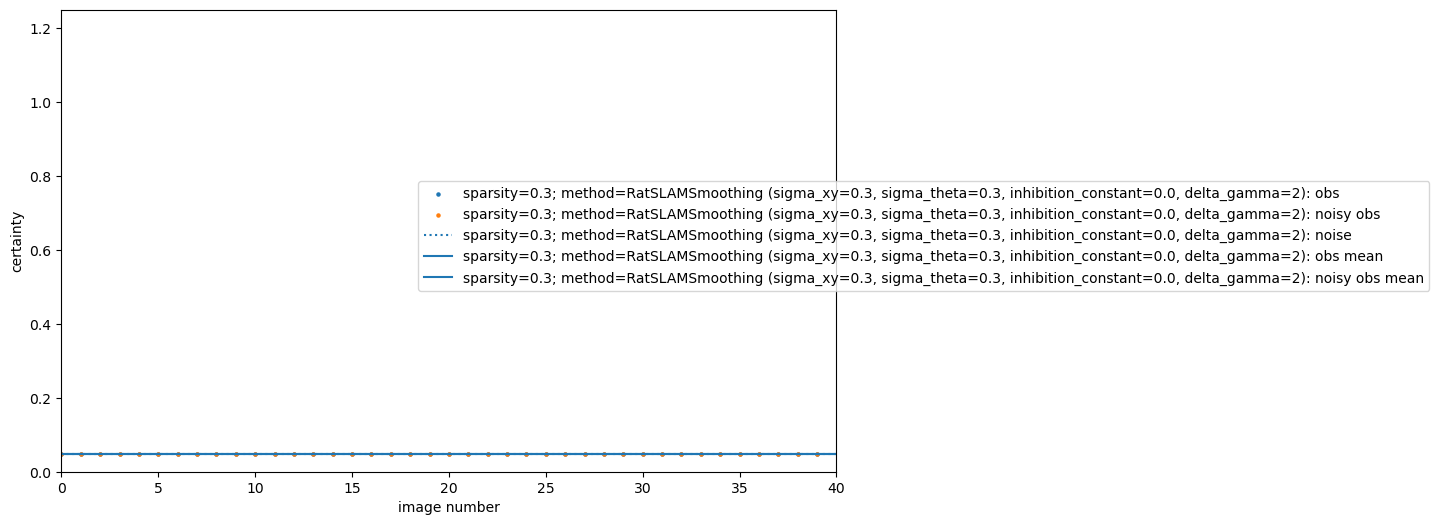

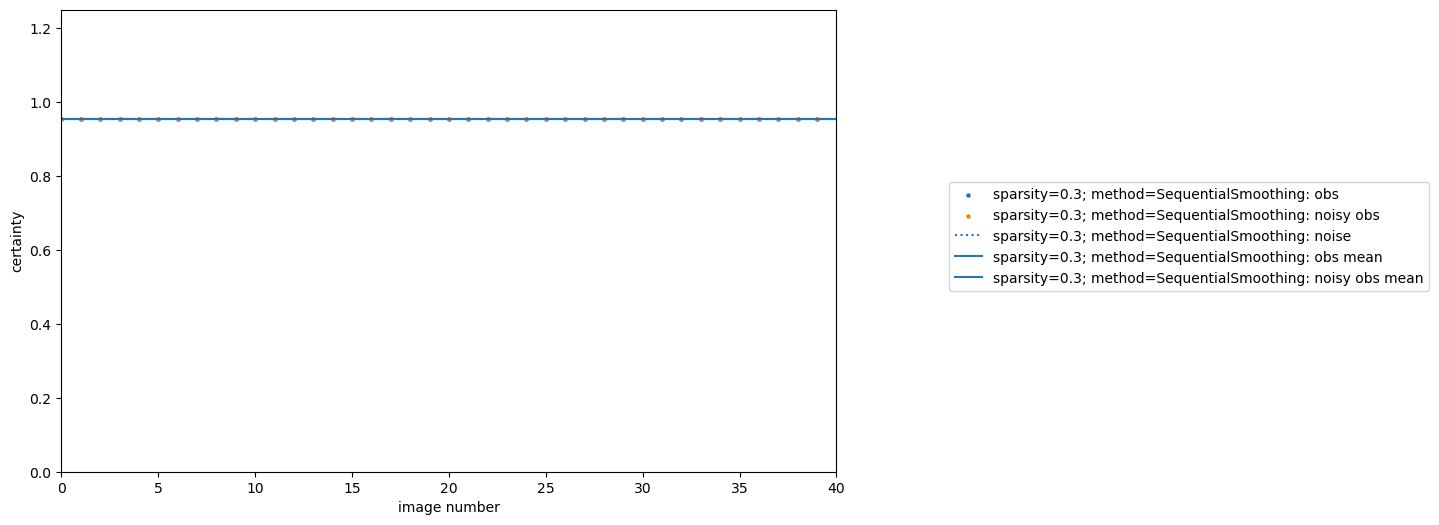

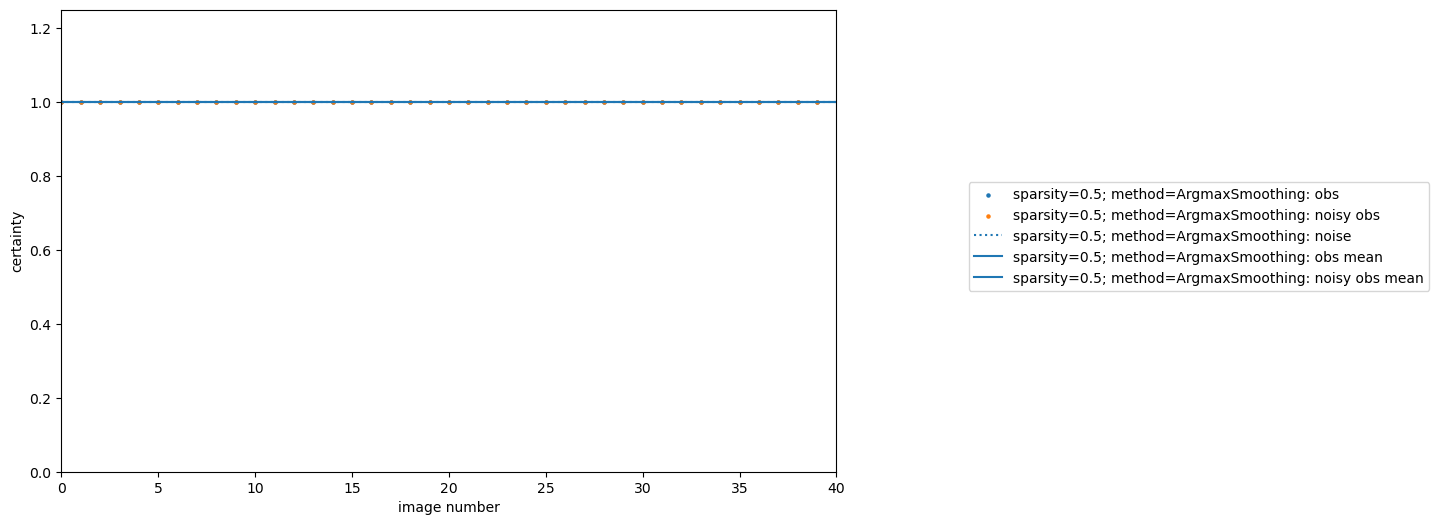

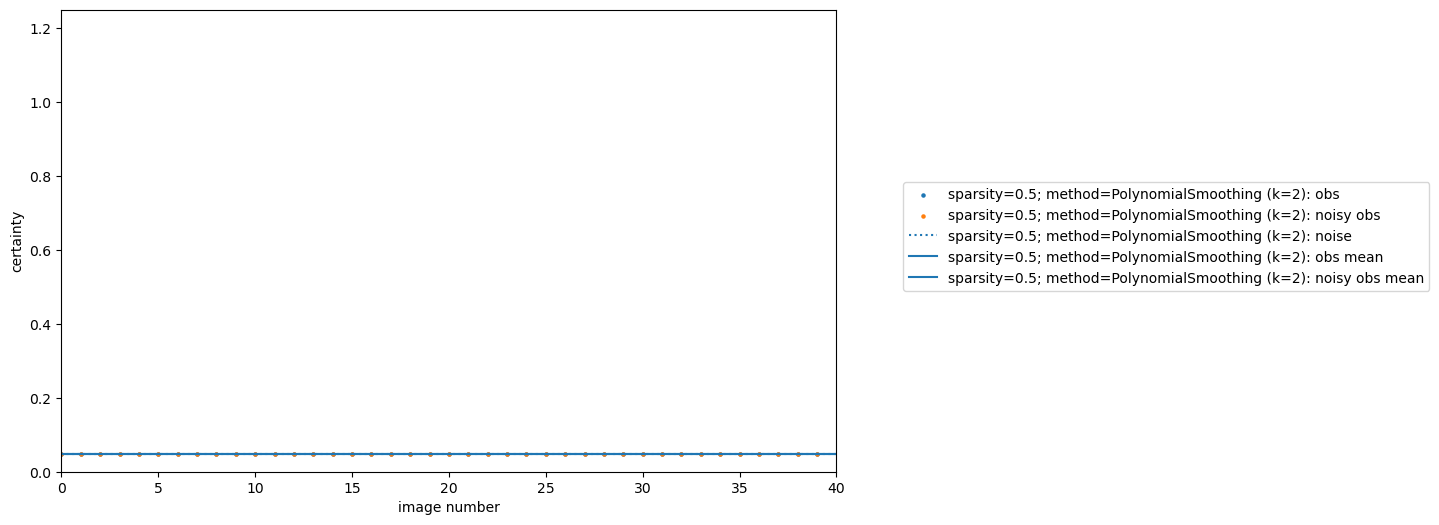

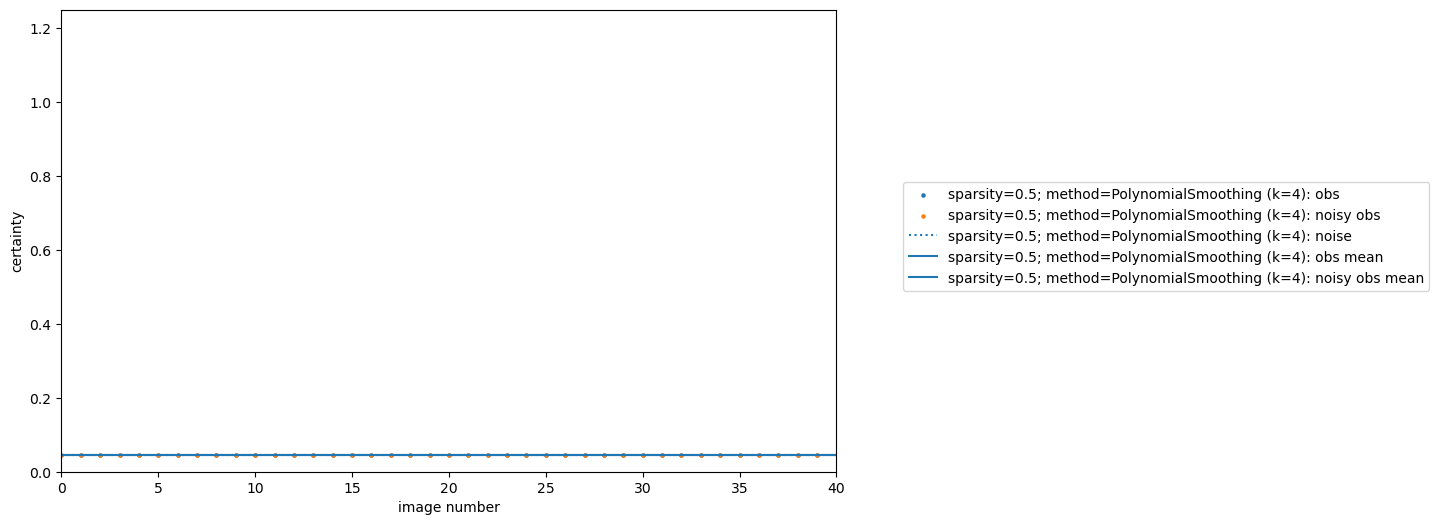

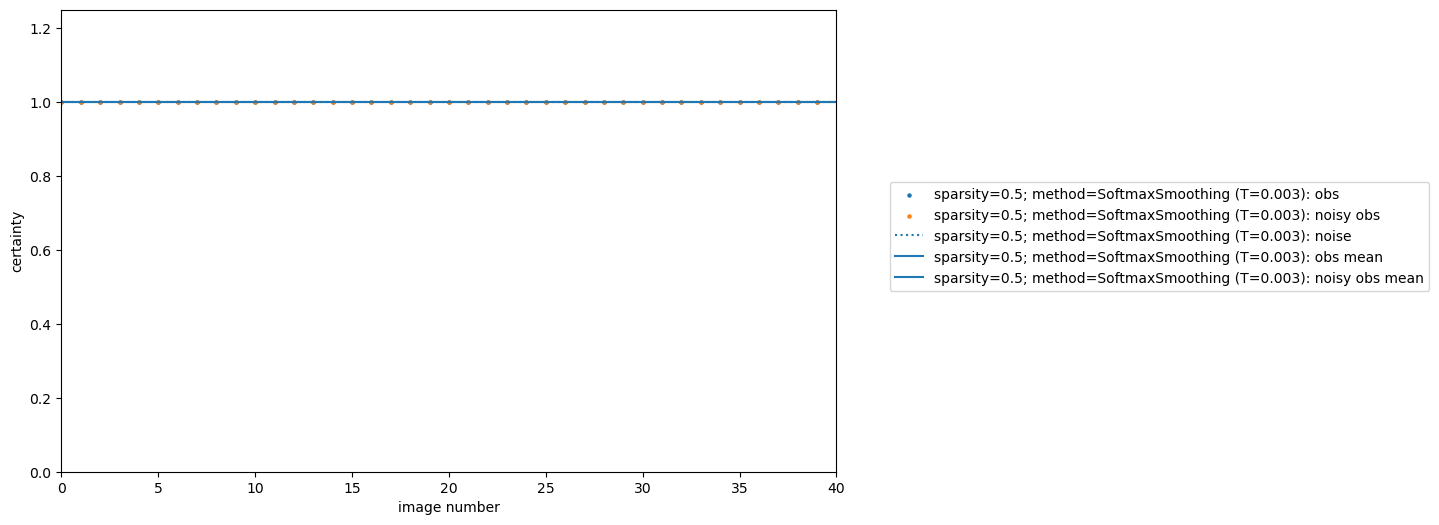

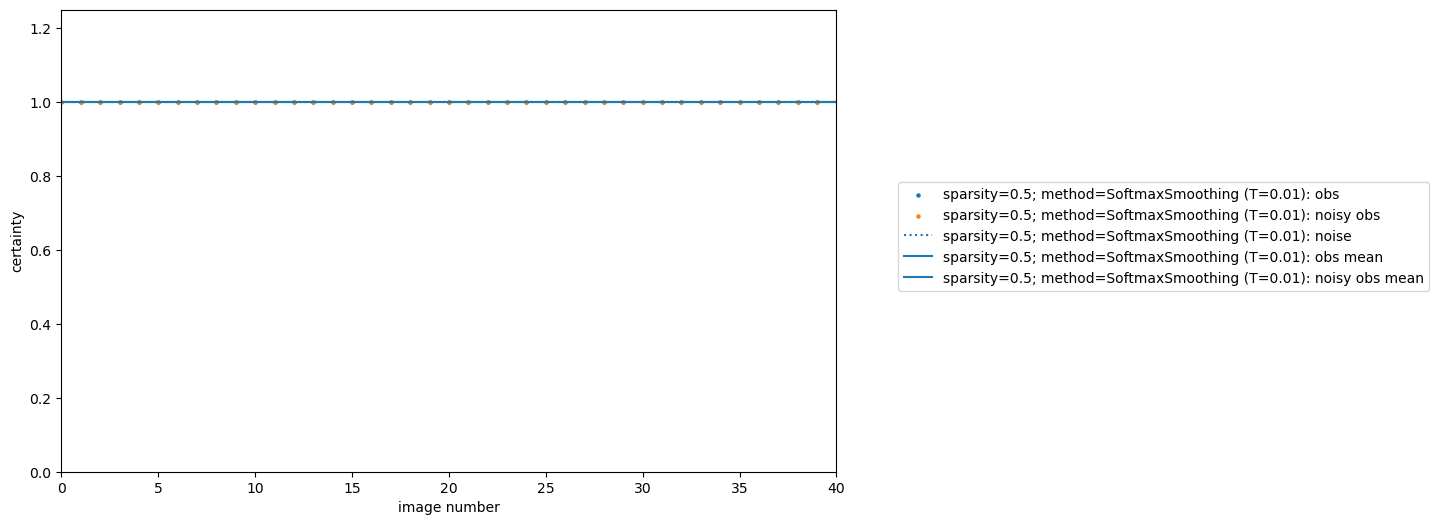

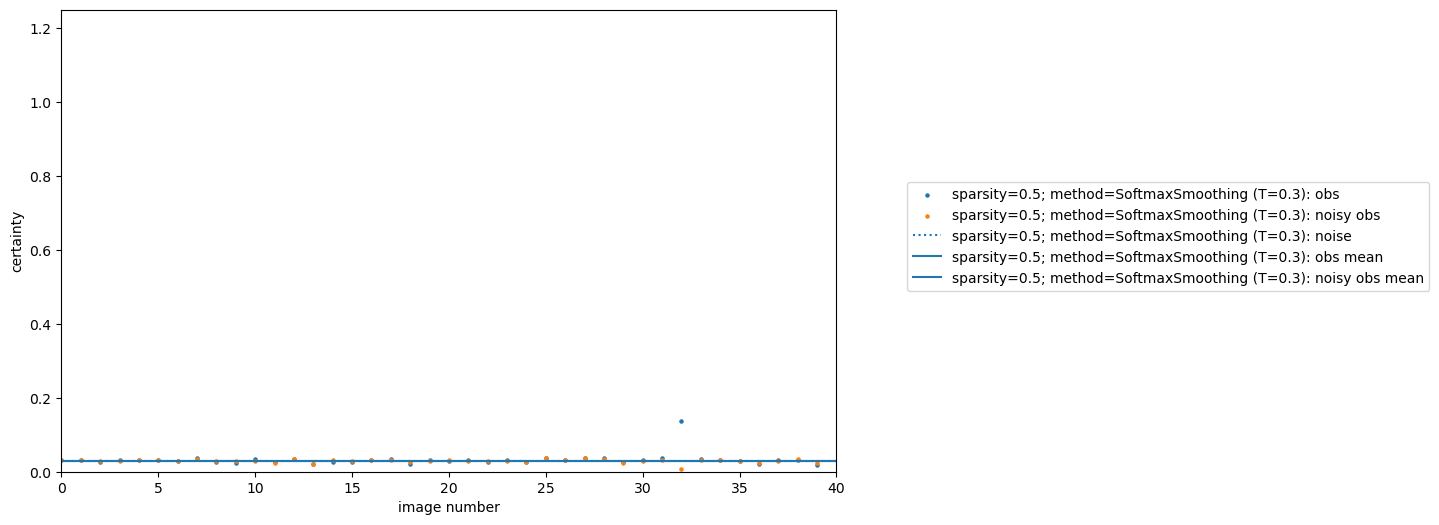

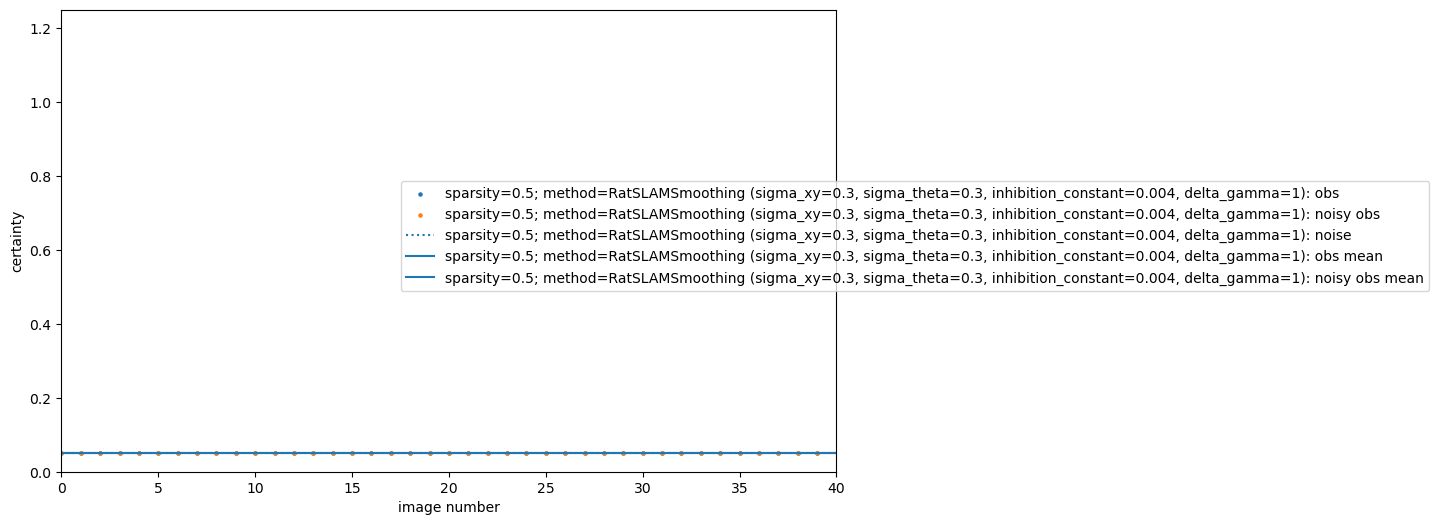

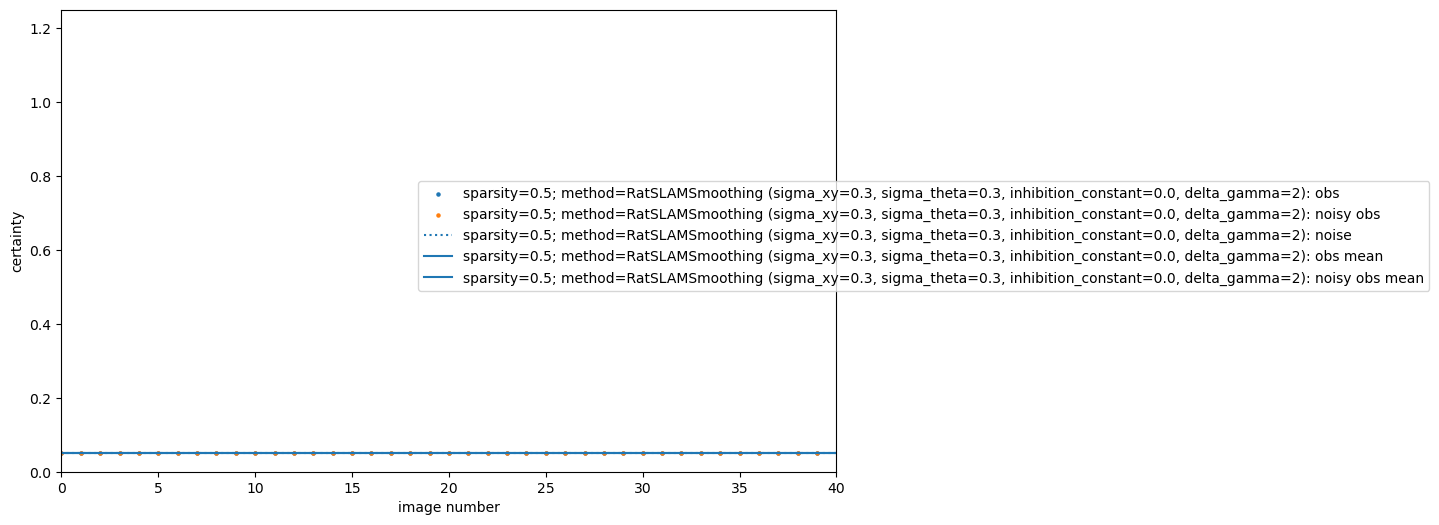

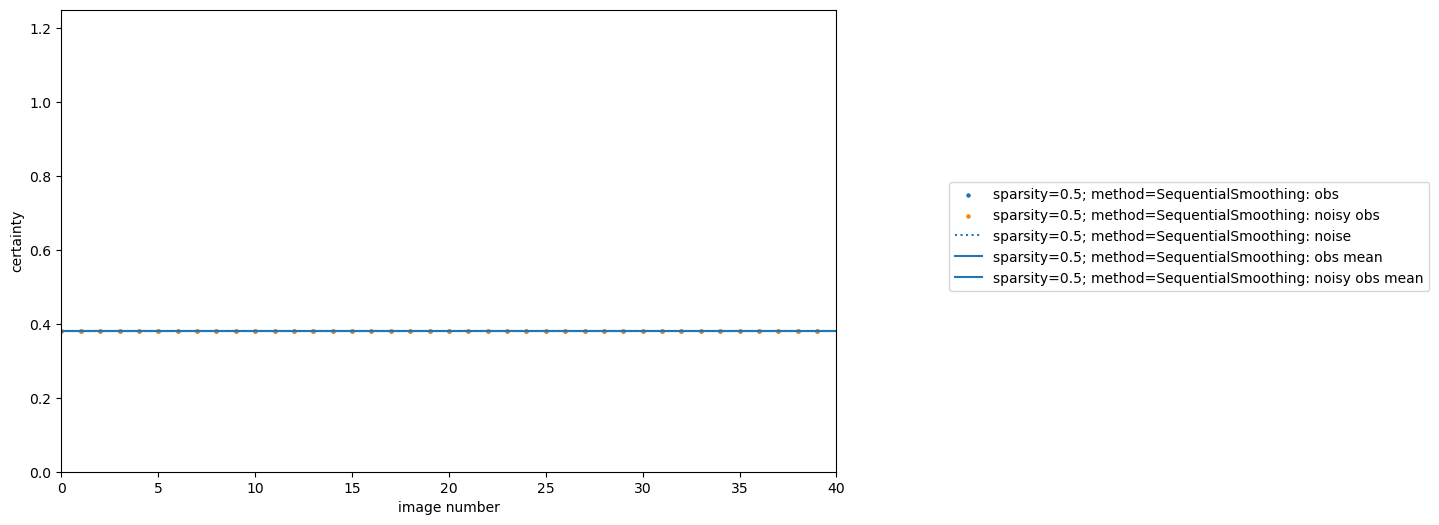

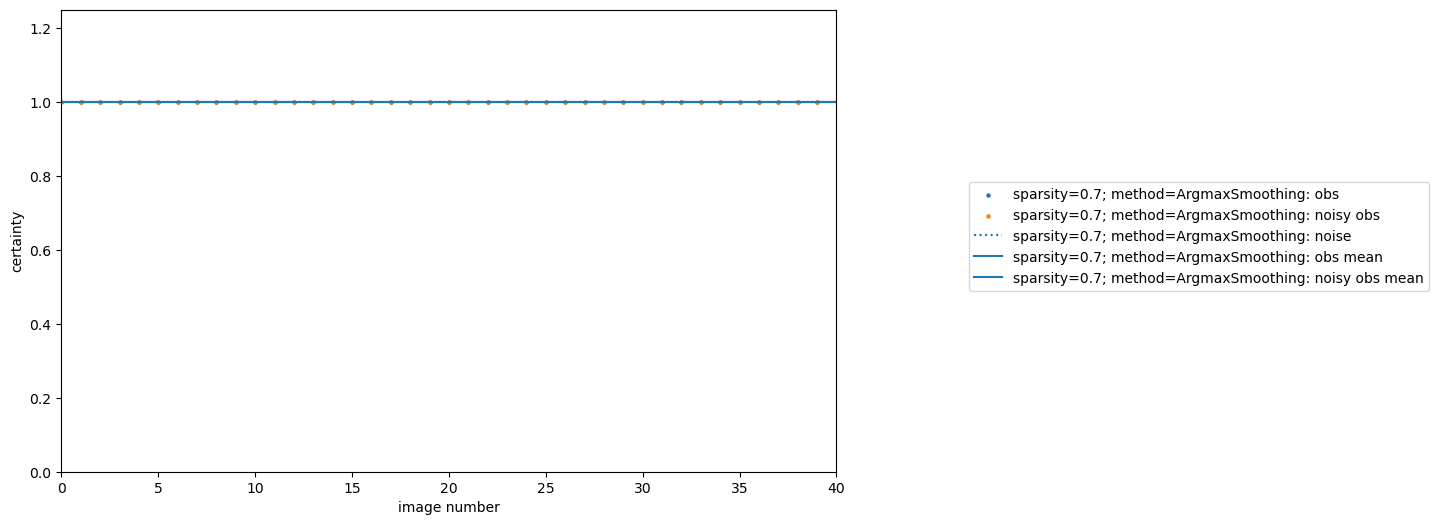

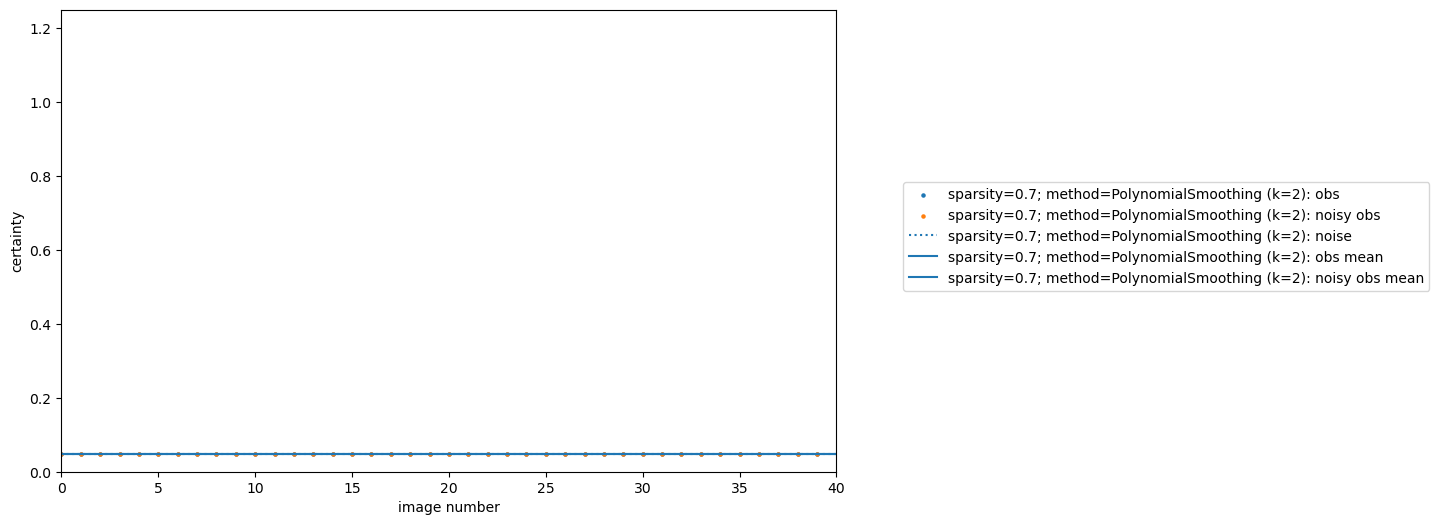

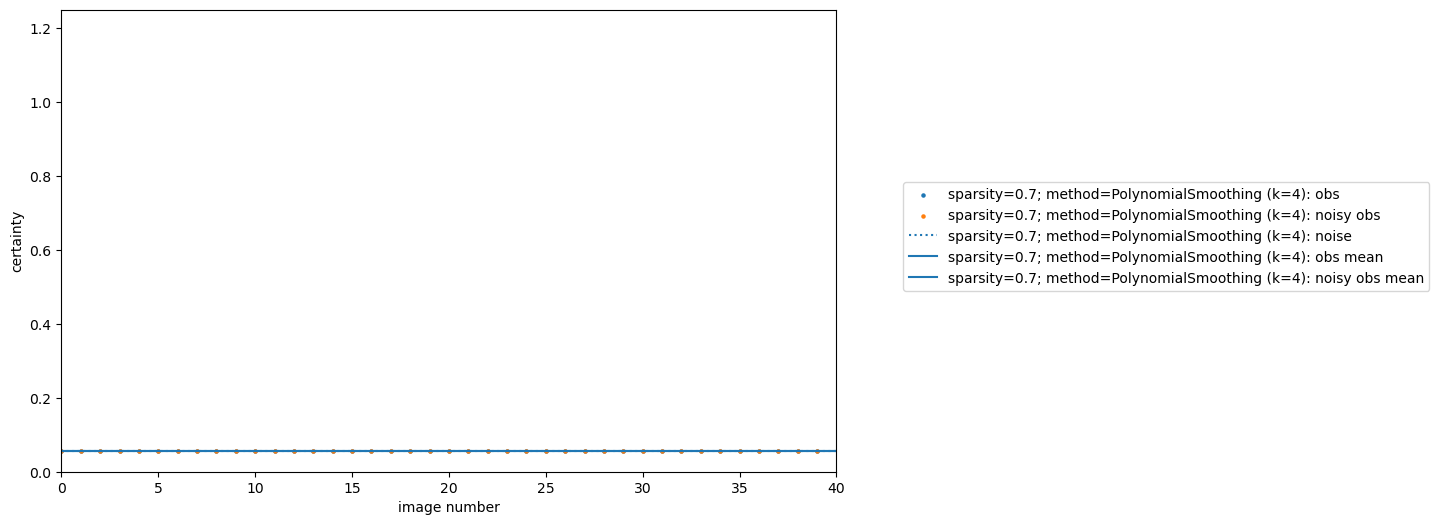

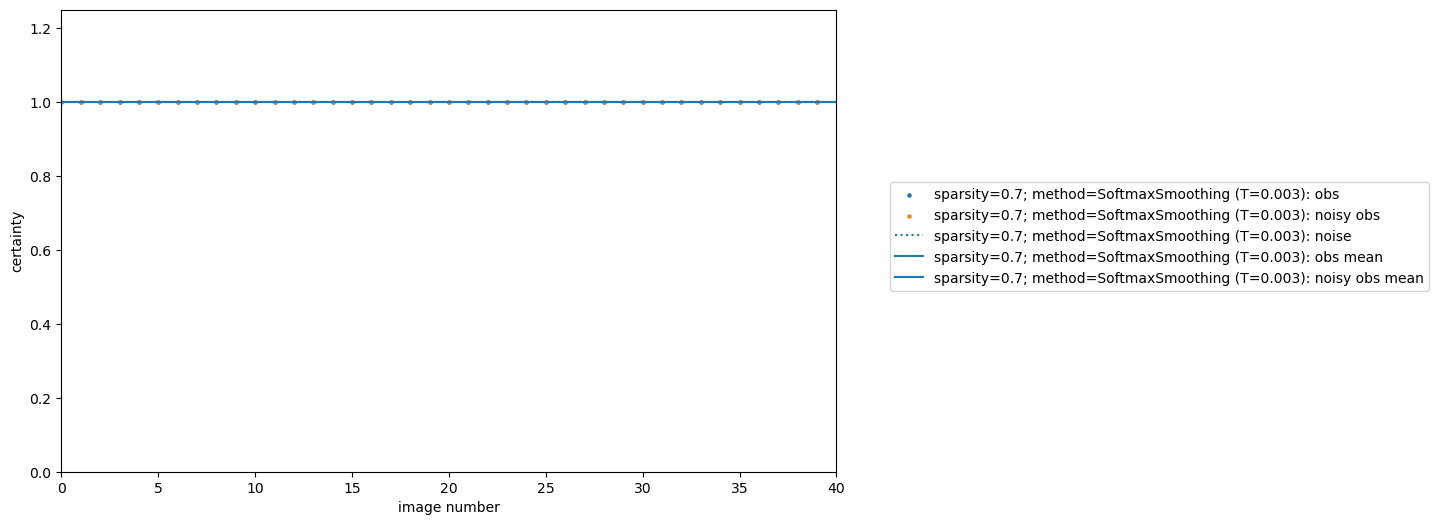

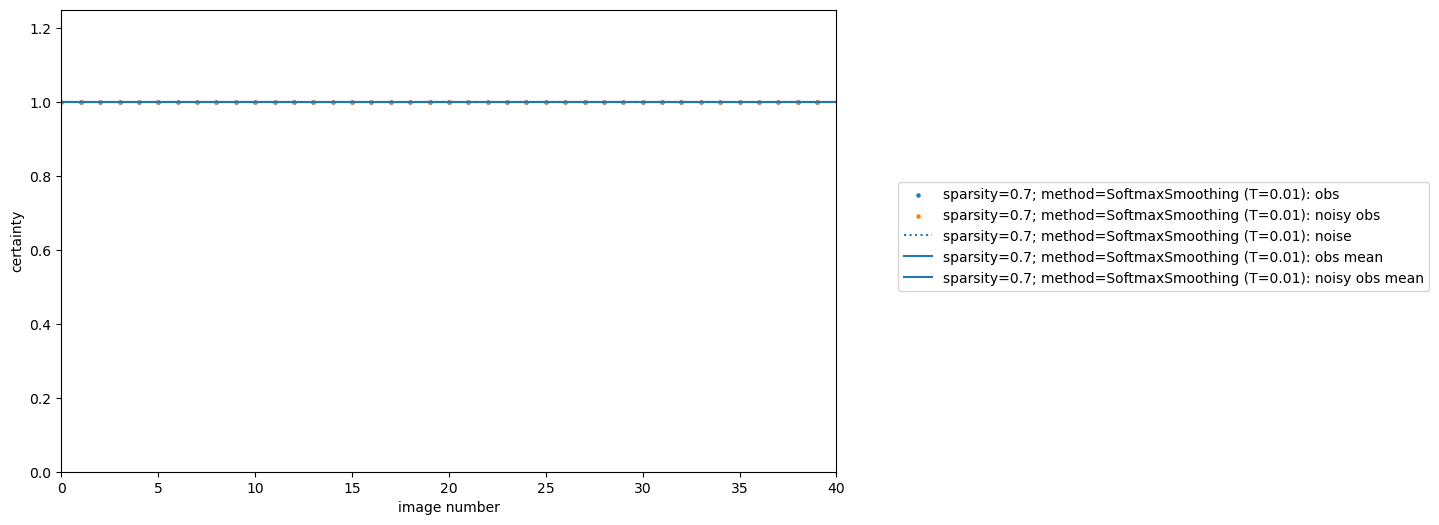

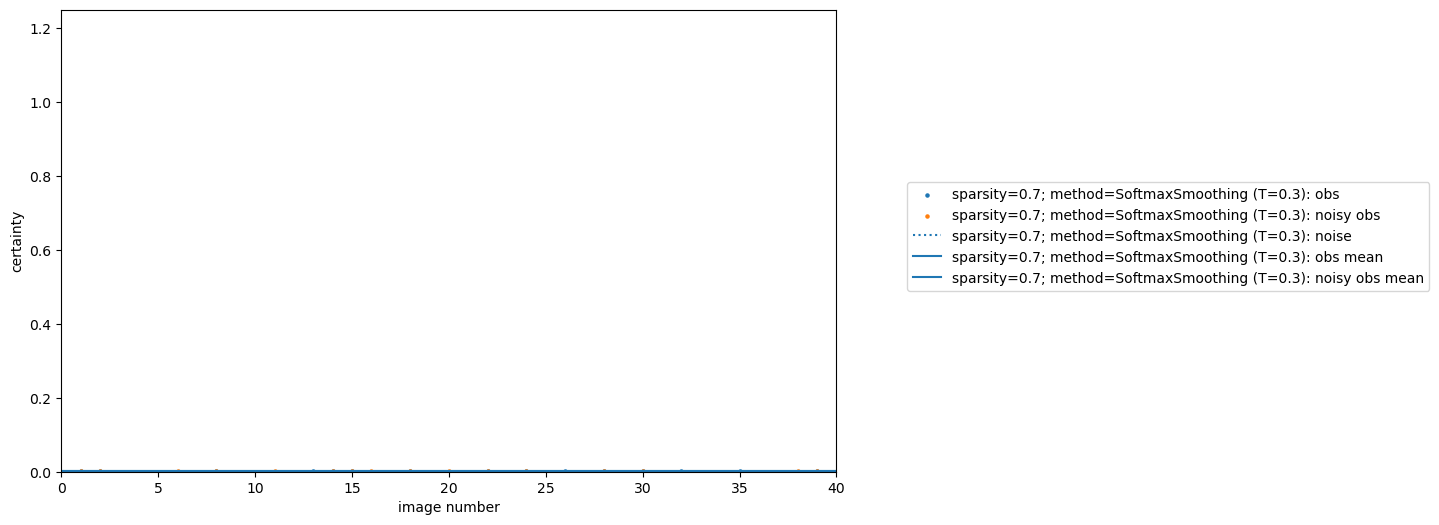

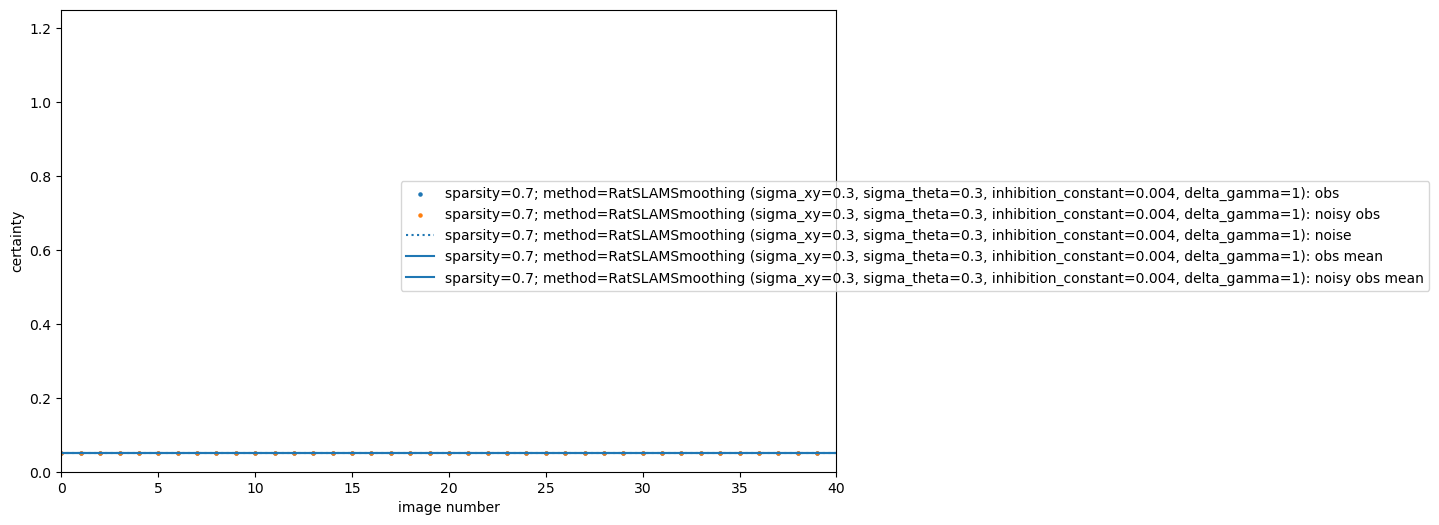

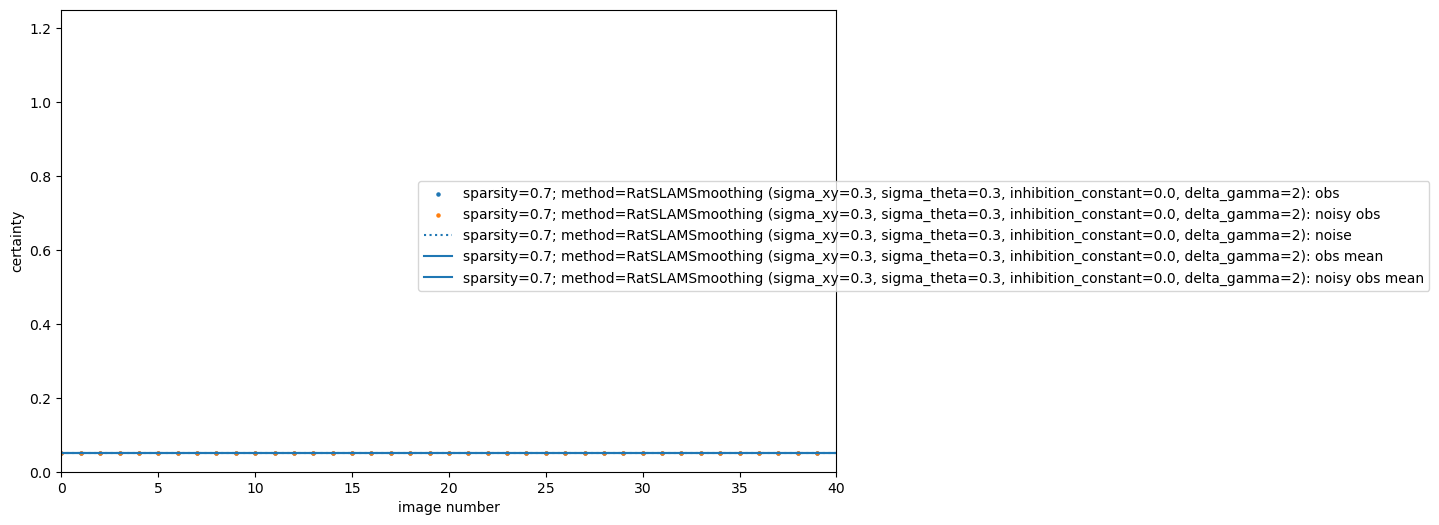

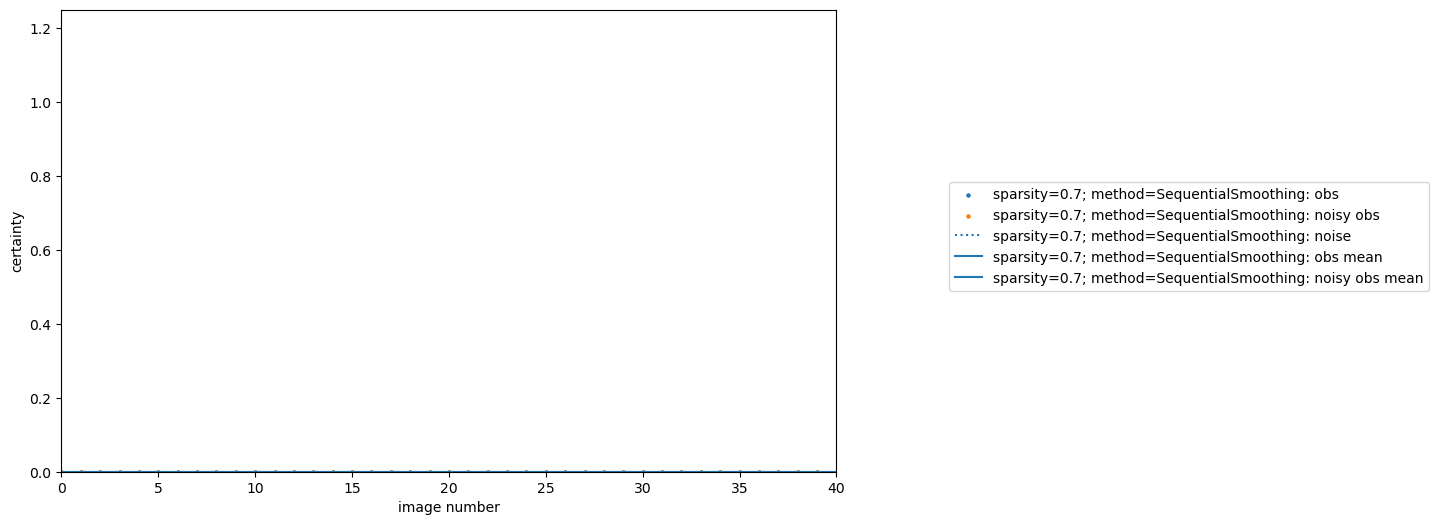

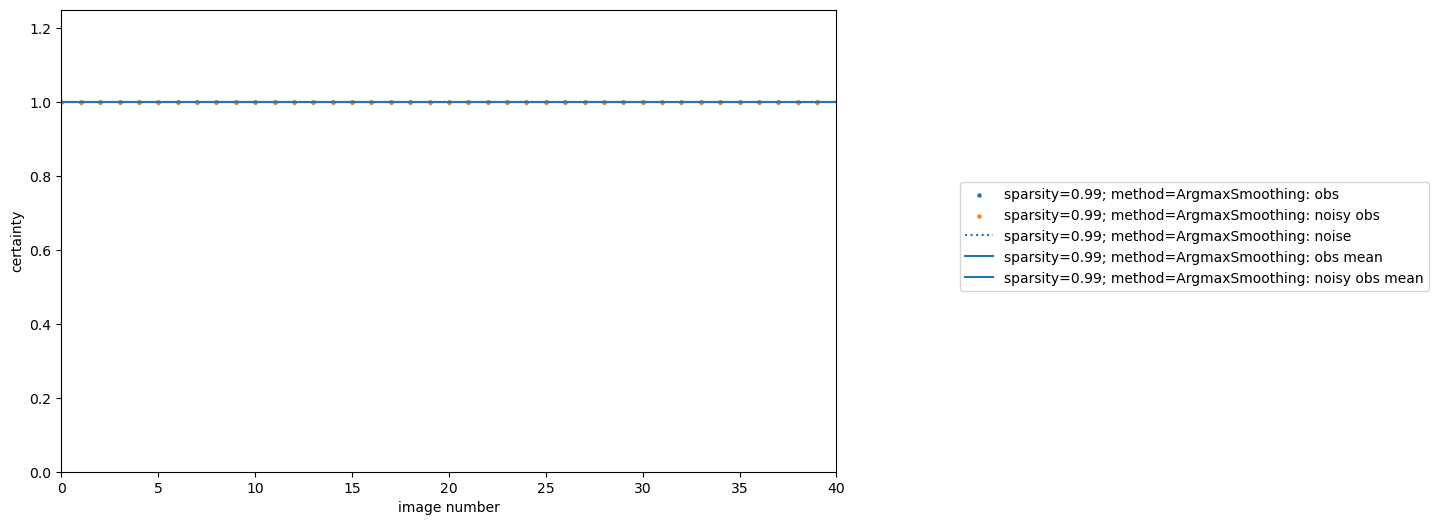

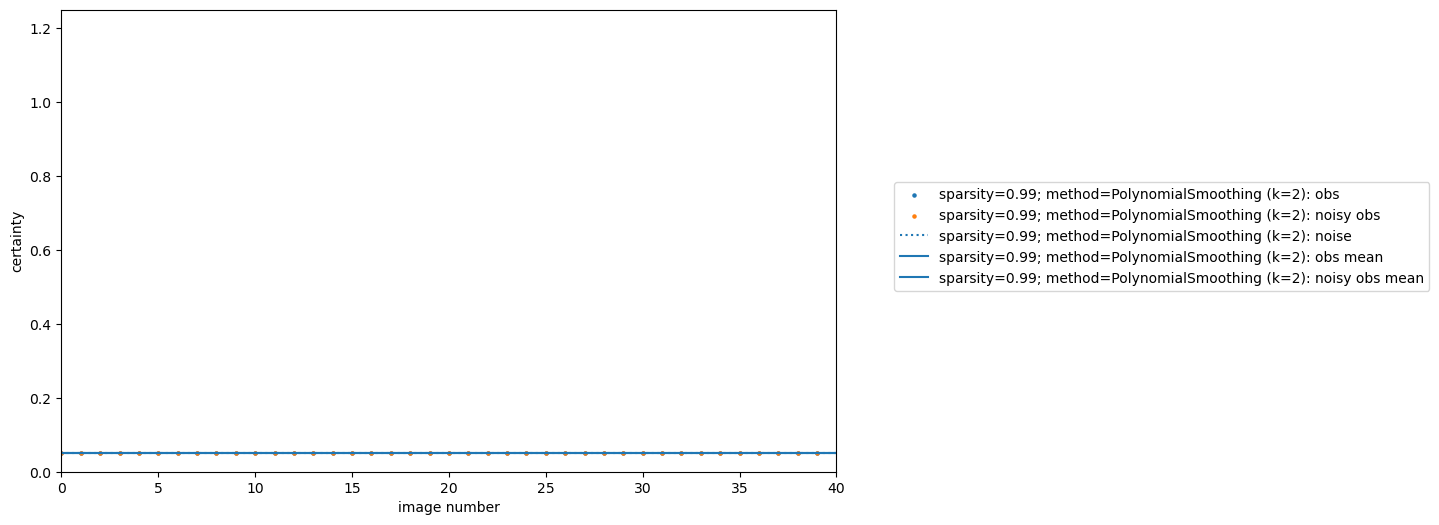

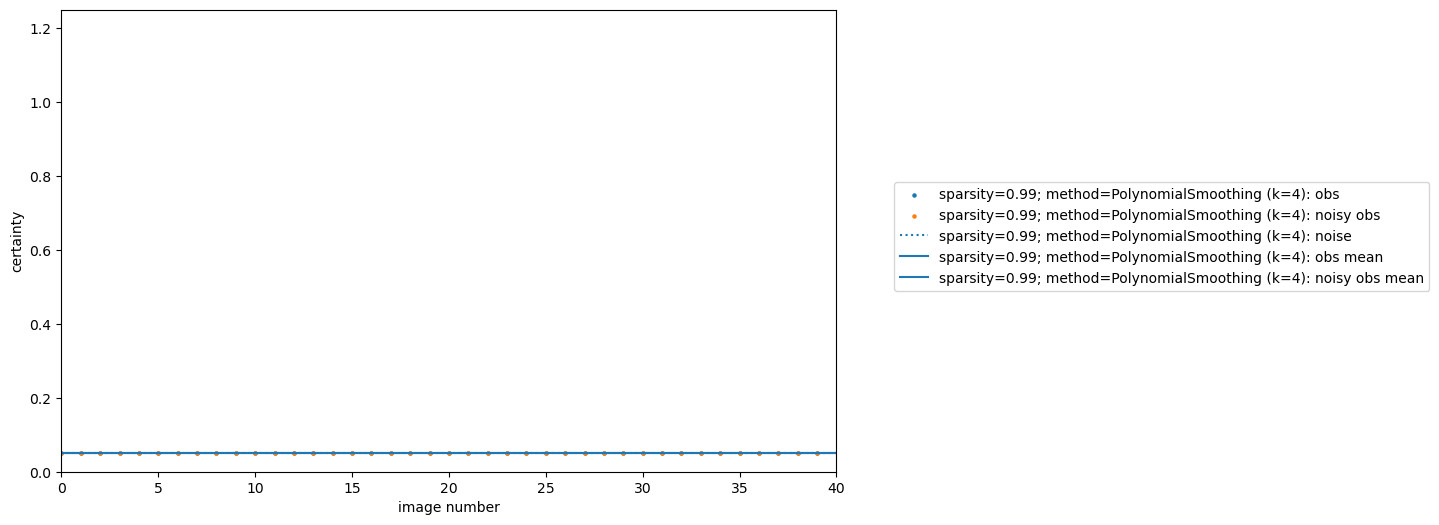

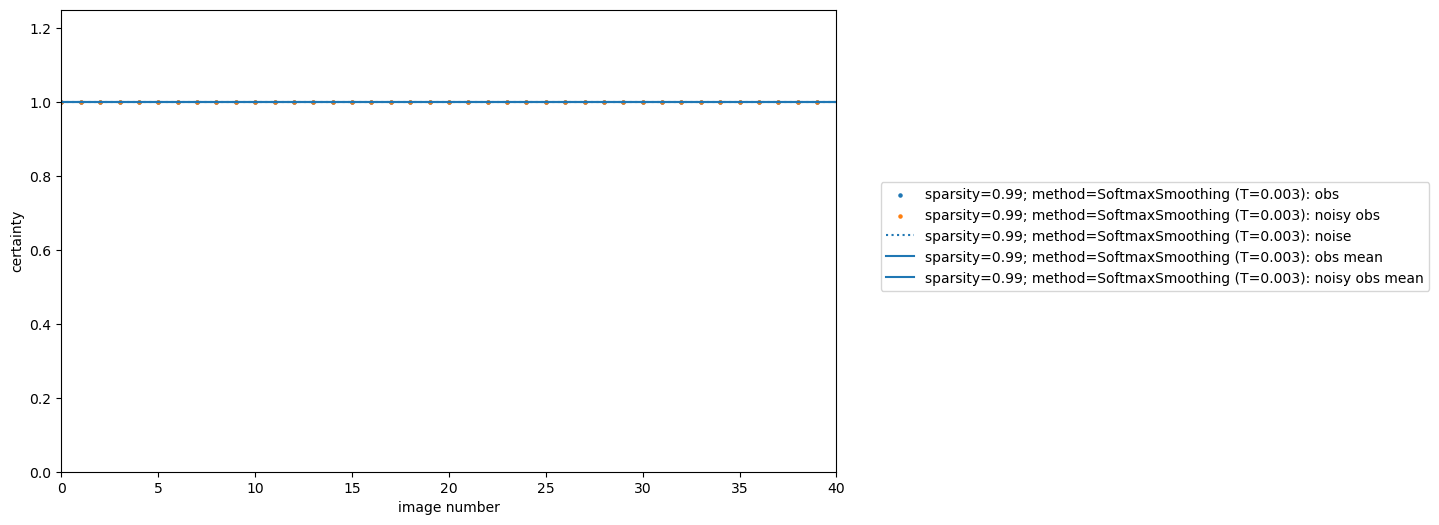

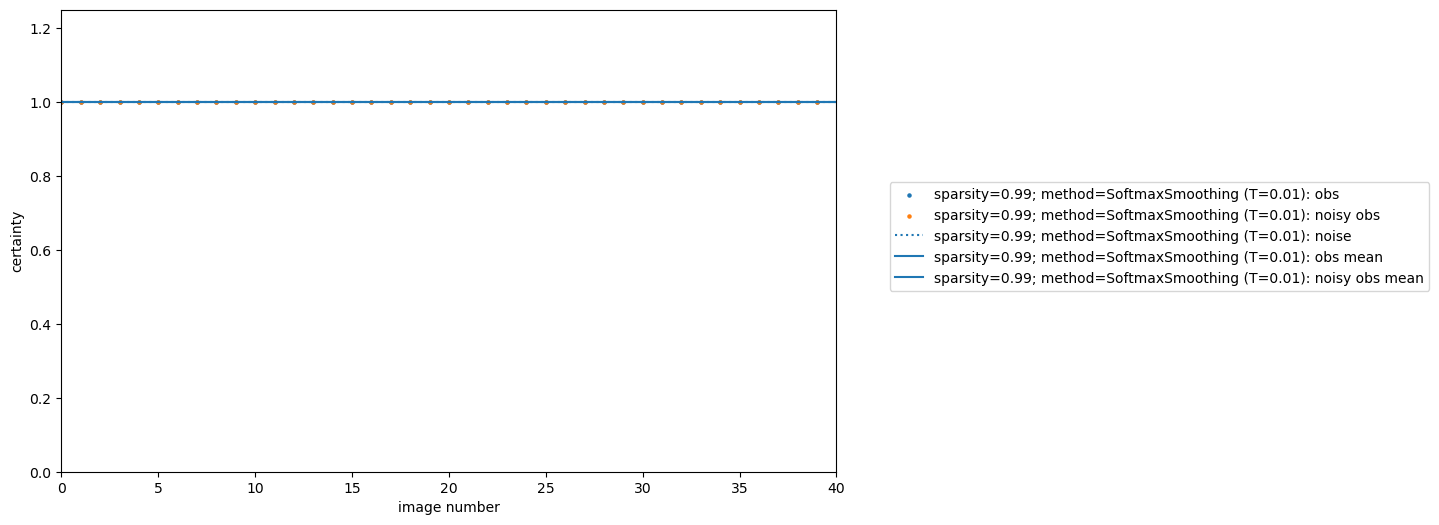

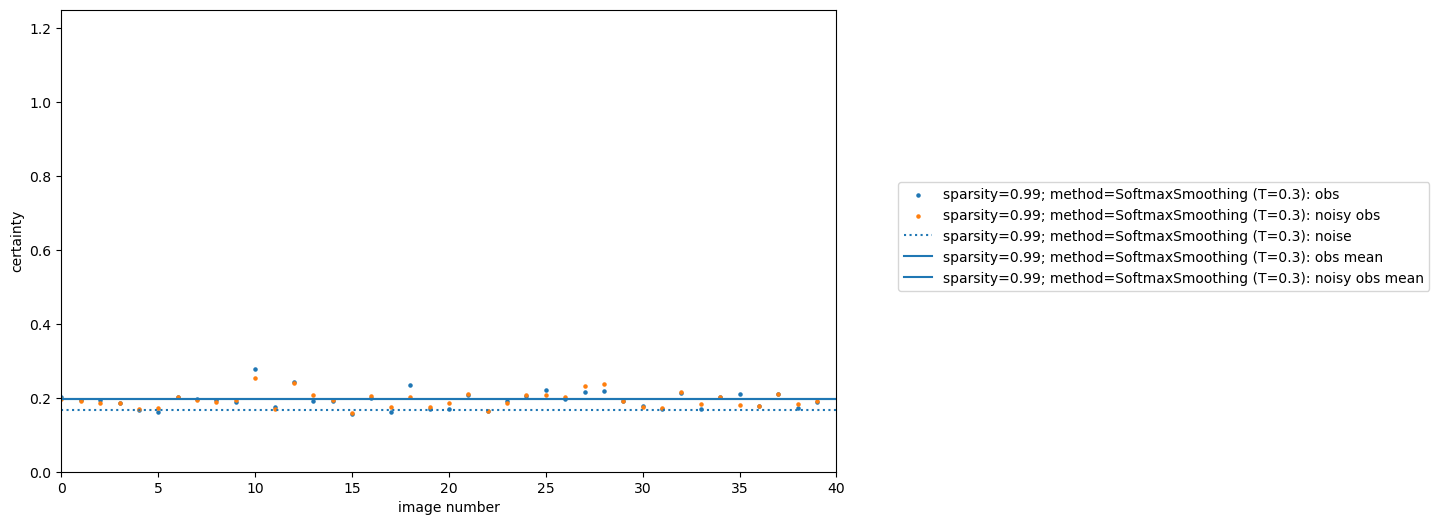

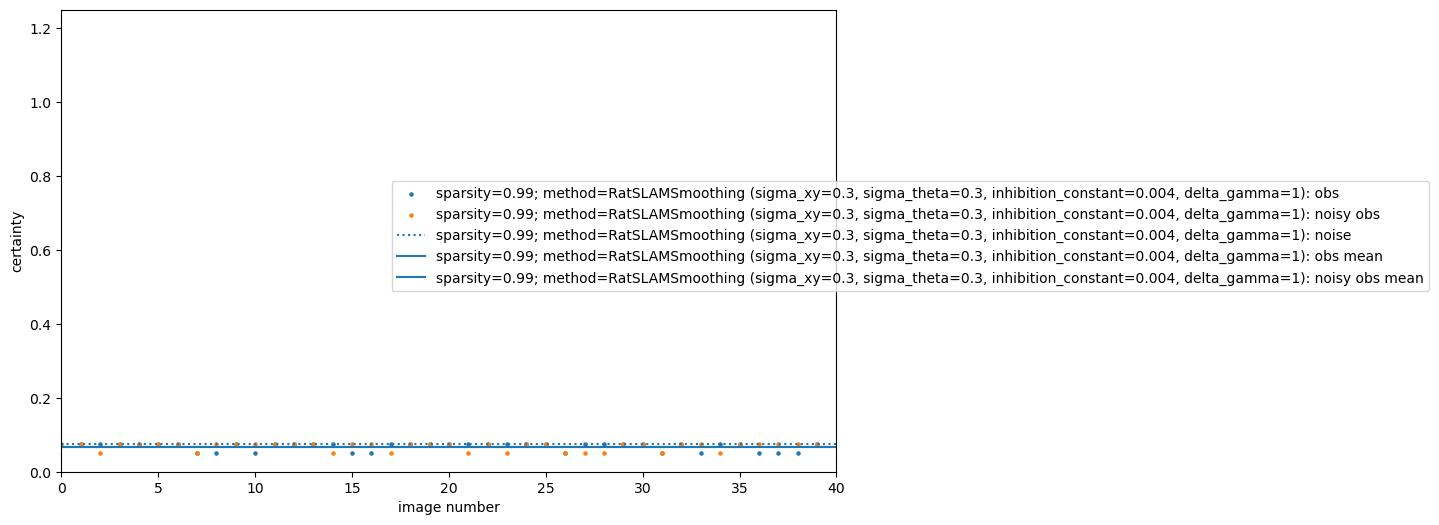

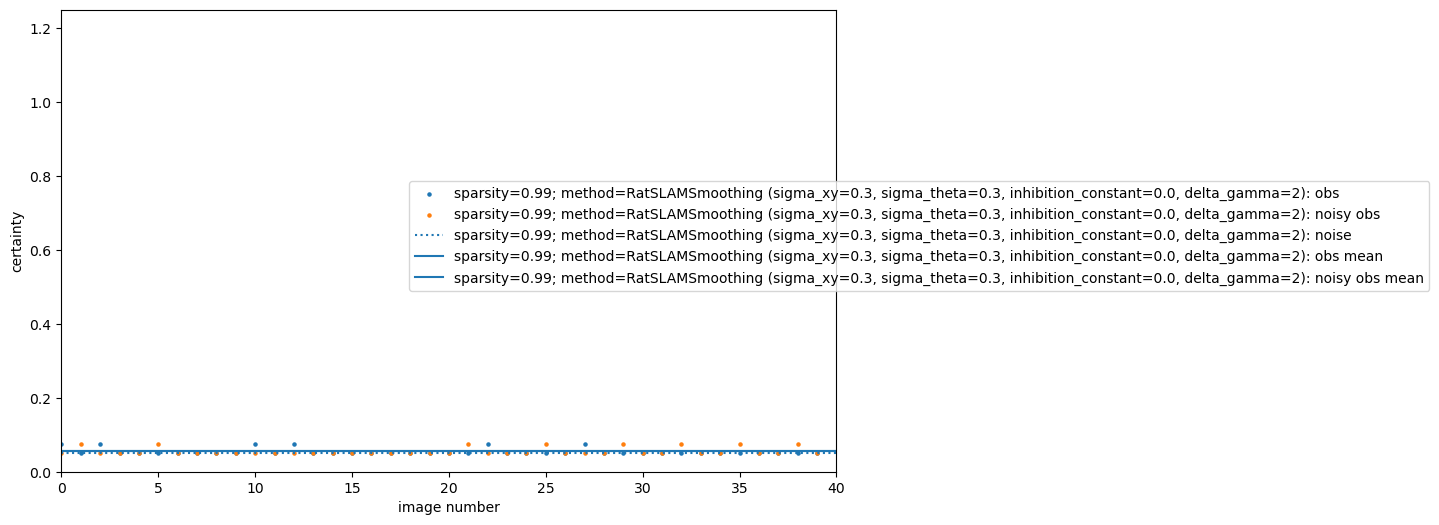

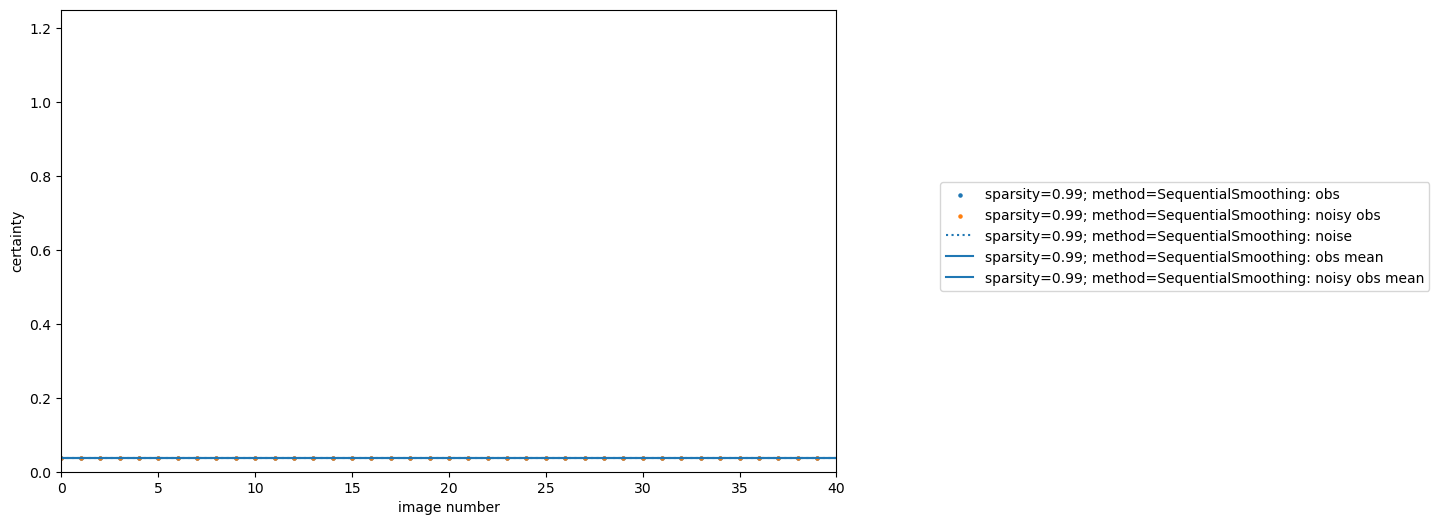

In [96]:
# obs_results = torch.ones(len(smoothings), N, 3, device=device)
# noisy_obs_results = torch.ones(len(smoothings), N, 3, device=device)


k = 40
dim = 2

for i, [sparsity, method] in enumerate(test_cases()):
    fig, ax = plt.subplots(figsize=(10, 6))
    label_base = f"sparsity={sparsity}; method={method}:"
    
    ax.scatter(
        torch.arange(0, k),
        obs_results[i, :k, dim].cpu(),
        label=f"{label_base} obs",
        s=5,
    )
    ax.scatter(
        torch.arange(0, k),
        noisy_obs_results[i, :k, dim].cpu(),
        label=f"{label_base} noisy obs",
        s=5,
    )
    ax.axhline(
        y=noise_results[i, dim].cpu(),
        label=f"{label_base} noise ",
        linestyle=":",
    )
    ax.axhline(
        y=obs_results[i, :, dim].cpu().mean(),
        label=f"{label_base} obs mean",
    )
    ax.axhline(
        y=noisy_obs_results[i, :, dim].cpu().mean(),
        label=f"{label_base} noisy obs mean",
    )

    ax.set_ylim(0, 1.25)
    ax.set_xlim(0, k)
    ax.legend(
        bbox_to_anchor=(1.5, 0.4), loc="lower right", bbox_transform=plt.gcf().transFigure
    )
    ax.set_xlabel("image number")
    ax.set_ylabel("certainty")
    fig.savefig(f"{basedir}/certainty_{label_base}.png", bbox_inches='tight')